##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# MNIST classification

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/quantum/tutorials/mnist"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/quantum/blob/master/docs/tutorials/mnist.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/quantum/blob/master/docs/tutorials/mnist.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/quantum/docs/tutorials/mnist.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial builds a quantum neural network (QNN) to classify a simplified version of MNIST, similar to the approach used in <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al</a>. The performance of the quantum neural network on this classical data problem is compared with a classical neural network.

## Setup

In [2]:
!pip install -q tensorflow==2.1.0

Install TensorFlow Quantum:

In [3]:
!pip install -q tensorflow-quantum

Now import TensorFlow and the module dependencies:

In [4]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np
import seaborn as sns
import collections

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

## 1. Load the data

In this tutorial you will build a binary classifier to distinguish between the digits 3 and 6, following <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a> This section covers the data handling that:

- Loads the raw data from Keras.
- Filters the dataset to only 3s and 6s.
- Downscales the images so they fit can fit in a quantum computer.
- Removes any contradictory examples.
- Converts the binary images to Cirq circuits.
- Converts the Circ circuits to TensorFlow Quantum circuits. 

### 1.1 Load the raw data

Load the MNIST dataset distributed with Keras. 

In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_train))

    8192/11490434 [..............................] - ETA: 0s

 4816896/11490434 [===========>..................] - ETA: 0s

11493376/11490434 [==============================] - 0s 0us/step


Number of original training examples: 60000
Number of original test examples: 60000


Filter the dataset to keep just the 3s and 6s,  remove the other classes. At the same time convert the label, `y`, to boolean: `True` for `3` and `False` for 6. 

In [6]:
def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

In [7]:
x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 12049
Number of filtered test examples: 1968


Show the first example:

True


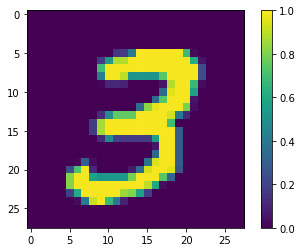

In [8]:
print(y_train[0])

plt.imshow(x_train[0, :, :, 0])
plt.colorbar()

### 1.2 Downscale the images

An image size of 28x28 is much too large for current quantum computers. Resize the image down to 4x4:

In [9]:
x_train_small = tf.image.resize(x_train, (4,4)).numpy()
x_test_small = tf.image.resize(x_test, (4,4)).numpy()

Again, display the first training example—after resize: 

True


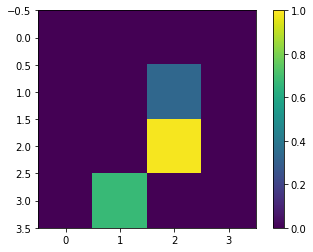

In [10]:
print(y_train[0])

plt.imshow(x_train_small[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()

### 1.3 Remove contradictory examples

From section *3.3 Learning to Distinguish Digits* of <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a>, filter the dataset to remove images that are labeled as belonging to both classes.

This is not a standard machine-learning procedure, but is included in the interest of following the paper.

In [11]:
def remove_contradicting(xs, ys):
    mapping = collections.defaultdict(set)
    # Determine the set of labels for each unique image:
    for x,y in zip(xs,ys):
       mapping[tuple(x.flatten())].add(y)
    
    new_x = []
    new_y = []
    for x,y in zip(xs, ys):
      labels = mapping[tuple(x.flatten())]
      if len(labels) == 1:
          new_x.append(x)
          new_y.append(list(labels)[0])
      else:
          # Throw out images that match more than one label.
          pass
    
    num_3 = sum(1 for value in mapping.values() if True in value)
    num_6 = sum(1 for value in mapping.values() if False in value)
    num_both = sum(1 for value in mapping.values() if len(value) == 2)

    print("Number of unique images:", len(mapping.values()))
    print("Number of 3s: ", num_3)
    print("Number of 6s: ", num_6)
    print("Number of contradictory images: ", num_both)
    print()
    print("Initial number of examples: ", len(xs))
    print("Remaining non-contradictory examples: ", len(new_x))
    
    return np.array(new_x), np.array(new_y)

The resulting counts do not closely match the reported values, but the exact procedure is not specified.

It is also worth noting here that applying filtering contradictory examples at this point does not totally prevent the model from receiving contradictory training examples: the next step binarizes the data which will cause more collisions. 

In [12]:
x_train_nocon, y_train_nocon = remove_contradicting(x_train_small, y_train)

Number of unique images: 10387
Number of 3s:  4961
Number of 6s:  5475
Number of contradictory images:  49

Initial number of examples:  12049
Remaining non-contradictory examples:  11520


### 1.3 Encode the data as quantum circuits

To process images using a quantum computer, <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a> proposed representing each pixel with a qubit, with the state depending on the value of the pixel. The first step is to convert to a binary encoding.

In [13]:
THRESHOLD = 0.5

x_train_bin = np.array(x_train_nocon > THRESHOLD, dtype=np.float32)
x_test_bin = np.array(x_test_small > THRESHOLD, dtype=np.float32)

The qubits at pixel indices with values that exceed a threshold, are rotated through an $X$ gate.

In [14]:
def convert_to_circuit(image):
    """Encode truncated classical image into quantum datapoint."""
    values = np.ndarray.flatten(image)
    qubits = cirq.GridQubit.rect(4, 4)
    circuit = cirq.Circuit()
    for i, value in enumerate(values):
        if value:
            circuit.append(cirq.X(qubits[i]))
    return circuit


x_train_circ = [convert_to_circuit(x) for x in x_train_bin]
x_test_circ = [convert_to_circuit(x) for x in x_test_bin]

Here is the circuit created for the first example (circuit diagrams do not show qubits with zero gates):

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


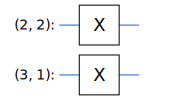

In [15]:
SVGCircuit(x_train_circ[0])

Compare this circuit to the indices where the image value exceeds the threshold:

In [16]:
bin_img = x_train_bin[0,:,:,0]
indices = np.array(np.where(bin_img)).T
indices

array([[2, 2],
       [3, 1]])

Convert these `Cirq` circuits to tensors for `tfq`:

In [17]:
x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

## 2. Quantum neural network

There is little guidance for a quantum circuit structure that classifies images. Since the classification is based on the expectation of the readout qubit, <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a> propose using two qubit gates, with the readout qubit always acted upon. This is similar in some ways to running small a <a href="https://arxiv.org/abs/1511.06464" class="external">Unitary RNN</a> across the pixels.

### 2.1 Build the model circuit

This following example shows this layered approach. Each layer uses *n* instances of the same gate, with each of the data qubits acting on the readout qubit.

Start with a simple class that will add a layer of these gates to a circuit:

In [18]:
class CircuitLayerBuilder():
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits
        self.readout = readout
    
    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            circuit.append(gate(qubit, self.readout)**symbol)

Build an example circuit layer to see how it looks:

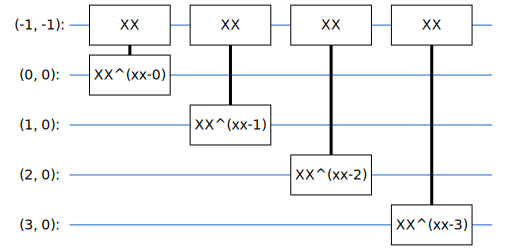

In [19]:
demo_builder = CircuitLayerBuilder(data_qubits = cirq.GridQubit.rect(4,1),
                                   readout=cirq.GridQubit(-1,-1))

circuit = cirq.Circuit()
demo_builder.add_layer(circuit, gate = cirq.XX, prefix='xx')
SVGCircuit(circuit)

Now build a two-layered model, matching the data-circuit size, and include the preparation and readout operations.

In [20]:
def create_quantum_model():
    """Create a QNN model circuit and readout operation to go along with it."""
    data_qubits = cirq.GridQubit.rect(4, 4)  # a 4x4 grid.
    readout = cirq.GridQubit(-1, -1)         # a single qubit at [-1,-1]
    circuit = cirq.Circuit()
    
    # Prepare the readout qubit.
    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))
    
    builder = CircuitLayerBuilder(
        data_qubits = data_qubits,
        readout=readout)

    # Then add layers (experiment by adding more).
    builder.add_layer(circuit, cirq.XX, "xx1")
    builder.add_layer(circuit, cirq.ZZ, "zz1")

    # Finally, prepare the readout qubit.
    circuit.append(cirq.H(readout))

    return circuit, cirq.Z(readout)

In [21]:
model_circuit, model_readout = create_quantum_model()

### 2.2 Wrap the model-circuit in a tfq-keras model

Build the Keras model with the quantum components. This model is fed the "quantum data", from `x_train_circ`, that encodes the classical data. It uses a *Parametrized Quantum Circuit* layer, `tfq.layers.PQC`, to train the model circuit, on the quantum data.

To classify these images, <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a> proposed taking the expectation of a readout qubit in a parameterized circuit. The expectation returns a value between 1 and -1.

In [22]:
# Build the Keras model.
model = tf.keras.Sequential([
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # The PQC layer returns the expected value of the readout gate, range [-1,1].
    tfq.layers.PQC(model_circuit, model_readout),
])

Next, describe the training procedure to the model, using the `compile` method.

Since the the expected readout is in the range `[-1,1]`, optimizing the hinge loss is a somewhat natural fit. 

Note: Another valid approach would be to shift the output range to `[0,1]`, and treat it as the probability the model assigns to class `3`. This could be used with a standard a `tf.losses.BinaryCrossentropy` loss.

To use the hinge loss here you need to make two small adjustments. First convert the labels, `y_train`, from boolean to `[-1,1]`, as expected by the hinge loss.

In [23]:
y_train_hinge = 2.0*y_train-1.0
y_test_hinge = 2.0*y_test-1.0

Second, use a custiom `hinge_accuracy` metric that correctly handles `[-1, 1]` as the `y_true` labels argument. 
`tf.losses.BinaryAccuracy(threshold=0.0)` expects `y_true` to be a boolean, and so can't be used with hinge loss).

In [24]:
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

In [25]:
model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])

In [26]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc (PQC)                    (None, 1)                 32        
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________
None


### Train the quantum model

Now train the model—this takes about 45 min. If you don't want to wait that long, use a small subset of the data (set `NUM_EXAMPLES=500`, below). This doesn't really affect the model's progress during training (it only has 32 parameters, and doesn't need much data to constrain these). Using fewer examples just ends training earlier (5min), but runs long enough to show that it is making progress in the validation logs.

In [27]:
EPOCHS = 3
BATCH_SIZE = 32

NUM_EXAMPLES = len(x_train_tfcirc)

In [28]:
x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

Training this model to convergence should achieve >85% accuracy on the test set.

In [29]:
qnn_history = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=32,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge))

qnn_results = model.evaluate(x_test_tfcirc, y_test)

Train on 11520 samples, validate on 1968 samples
Epoch 1/3


   32/11520 [..............................] - ETA: 14:01 - loss: 1.0006 - hinge_accuracy: 0.4375

   64/11520 [..............................] - ETA: 10:10 - loss: 1.0005 - hinge_accuracy: 0.4531

   96/11520 [..............................] - ETA: 8:50 - loss: 1.0010 - hinge_accuracy: 0.4167 

  128/11520 [..............................] - ETA: 8:09 - loss: 1.0012 - hinge_accuracy: 0.4062

  160/11520 [..............................] - ETA: 7:44 - loss: 1.0009 - hinge_accuracy: 0.4375

  192/11520 [..............................] - ETA: 7:28 - loss: 1.0004 - hinge_accuracy: 0.4740

  224/11520 [..............................] - ETA: 7:16 - loss: 1.0004 - hinge_accuracy: 0.4777

  256/11520 [..............................] - ETA: 7:06 - loss: 1.0001 - hinge_accuracy: 0.4922

  288/11520 [..............................] - ETA: 6:58 - loss: 1.0001 - hinge_accuracy: 0.5000

  320/11520 [..............................] - ETA: 6:52 - loss: 1.0002 - hinge_accuracy: 0.4875

  352/11520 [..............................] - ETA: 6:47 - loss: 1.0001 - hinge_accuracy: 0.4915

  384/11520 [>.............................] - ETA: 6:43 - loss: 1.0002 - hinge_accuracy: 0.4844

  416/11520 [>.............................] - ETA: 6:39 - loss: 1.0002 - hinge_accuracy: 0.4856

  448/11520 [>.............................] - ETA: 6:35 - loss: 1.0002 - hinge_accuracy: 0.4866

  480/11520 [>.............................] - ETA: 6:31 - loss: 1.0002 - hinge_accuracy: 0.4833

  512/11520 [>.............................] - ETA: 6:28 - loss: 1.0003 - hinge_accuracy: 0.4785

  544/11520 [>.............................] - ETA: 6:25 - loss: 1.0004 - hinge_accuracy: 0.4706

  576/11520 [>.............................] - ETA: 6:23 - loss: 1.0004 - hinge_accuracy: 0.4740

  608/11520 [>.............................] - ETA: 6:20 - loss: 1.0004 - hinge_accuracy: 0.4737

  640/11520 [>.............................] - ETA: 6:18 - loss: 1.0004 - hinge_accuracy: 0.4734

  672/11520 [>.............................] - ETA: 6:15 - loss: 1.0004 - hinge_accuracy: 0.4747

  704/11520 [>.............................] - ETA: 6:13 - loss: 1.0004 - hinge_accuracy: 0.4744

  736/11520 [>.............................] - ETA: 6:11 - loss: 1.0003 - hinge_accuracy: 0.4742

  768/11520 [=>............................] - ETA: 6:09 - loss: 1.0003 - hinge_accuracy: 0.4792

  800/11520 [=>............................] - ETA: 6:07 - loss: 1.0003 - hinge_accuracy: 0.4787

  832/11520 [=>............................] - ETA: 6:05 - loss: 1.0003 - hinge_accuracy: 0.4796

  864/11520 [=>............................] - ETA: 6:03 - loss: 1.0002 - hinge_accuracy: 0.4861

  896/11520 [=>............................] - ETA: 6:01 - loss: 1.0002 - hinge_accuracy: 0.4900

  928/11520 [=>............................] - ETA: 6:00 - loss: 1.0002 - hinge_accuracy: 0.4903

  960/11520 [=>............................] - ETA: 5:58 - loss: 1.0001 - hinge_accuracy: 0.4948

  992/11520 [=>............................] - ETA: 5:56 - loss: 1.0002 - hinge_accuracy: 0.4899

 1024/11520 [=>............................] - ETA: 5:55 - loss: 1.0002 - hinge_accuracy: 0.4922

 1056/11520 [=>............................] - ETA: 5:53 - loss: 1.0001 - hinge_accuracy: 0.4924

 1088/11520 [=>............................] - ETA: 5:51 - loss: 1.0002 - hinge_accuracy: 0.4908

 1120/11520 [=>............................] - ETA: 5:50 - loss: 1.0002 - hinge_accuracy: 0.4857

 1152/11520 [==>...........................] - ETA: 5:48 - loss: 1.0002 - hinge_accuracy: 0.4896

 1184/11520 [==>...........................] - ETA: 5:47 - loss: 1.0002 - hinge_accuracy: 0.4899

 1216/11520 [==>...........................] - ETA: 5:45 - loss: 1.0001 - hinge_accuracy: 0.4942

 1248/11520 [==>...........................] - ETA: 5:44 - loss: 1.0001 - hinge_accuracy: 0.4952

 1280/11520 [==>...........................] - ETA: 5:42 - loss: 1.0001 - hinge_accuracy: 0.4969

 1312/11520 [==>...........................] - ETA: 5:41 - loss: 1.0001 - hinge_accuracy: 0.4970

 1344/11520 [==>...........................] - ETA: 5:39 - loss: 1.0001 - hinge_accuracy: 0.4940

 1376/11520 [==>...........................] - ETA: 5:38 - loss: 1.0001 - hinge_accuracy: 0.4935

 1408/11520 [==>...........................] - ETA: 5:37 - loss: 1.0001 - hinge_accuracy: 0.4979

 1440/11520 [==>...........................] - ETA: 5:35 - loss: 1.0001 - hinge_accuracy: 0.4986

 1472/11520 [==>...........................] - ETA: 5:34 - loss: 1.0001 - hinge_accuracy: 0.4966

 1504/11520 [==>...........................] - ETA: 5:32 - loss: 1.0001 - hinge_accuracy: 0.4987

 1536/11520 [===>..........................] - ETA: 5:31 - loss: 1.0001 - hinge_accuracy: 0.5000

 1568/11520 [===>..........................] - ETA: 5:30 - loss: 1.0001 - hinge_accuracy: 0.4981

 1600/11520 [===>..........................] - ETA: 5:28 - loss: 1.0001 - hinge_accuracy: 0.4950

 1632/11520 [===>..........................] - ETA: 5:27 - loss: 1.0001 - hinge_accuracy: 0.4908

 1664/11520 [===>..........................] - ETA: 5:26 - loss: 1.0001 - hinge_accuracy: 0.4904

 1696/11520 [===>..........................] - ETA: 5:24 - loss: 1.0001 - hinge_accuracy: 0.4923

 1728/11520 [===>..........................] - ETA: 5:23 - loss: 1.0001 - hinge_accuracy: 0.4931

 1760/11520 [===>..........................] - ETA: 5:22 - loss: 1.0001 - hinge_accuracy: 0.4938

 1792/11520 [===>..........................] - ETA: 5:20 - loss: 1.0001 - hinge_accuracy: 0.4950

 1824/11520 [===>..........................] - ETA: 5:19 - loss: 1.0001 - hinge_accuracy: 0.4956

 1856/11520 [===>..........................] - ETA: 5:18 - loss: 1.0001 - hinge_accuracy: 0.4957

 1888/11520 [===>..........................] - ETA: 5:17 - loss: 1.0001 - hinge_accuracy: 0.4947

 1920/11520 [====>.........................] - ETA: 5:16 - loss: 1.0001 - hinge_accuracy: 0.4927

 1952/11520 [====>.........................] - ETA: 5:15 - loss: 1.0001 - hinge_accuracy: 0.4959

 1984/11520 [====>.........................] - ETA: 5:13 - loss: 1.0001 - hinge_accuracy: 0.4960

 2016/11520 [====>.........................] - ETA: 5:12 - loss: 1.0001 - hinge_accuracy: 0.4970

 2048/11520 [====>.........................] - ETA: 5:11 - loss: 1.0001 - hinge_accuracy: 0.4976

 2080/11520 [====>.........................] - ETA: 5:10 - loss: 1.0000 - hinge_accuracy: 0.5005

 2112/11520 [====>.........................] - ETA: 5:08 - loss: 1.0000 - hinge_accuracy: 0.5005

 2144/11520 [====>.........................] - ETA: 5:07 - loss: 1.0001 - hinge_accuracy: 0.4991

 2176/11520 [====>.........................] - ETA: 5:06 - loss: 1.0001 - hinge_accuracy: 0.4954

 2208/11520 [====>.........................] - ETA: 5:05 - loss: 1.0001 - hinge_accuracy: 0.4955

 2240/11520 [====>.........................] - ETA: 5:04 - loss: 1.0001 - hinge_accuracy: 0.4951

 2272/11520 [====>.........................] - ETA: 5:03 - loss: 1.0001 - hinge_accuracy: 0.4952

 2304/11520 [=====>........................] - ETA: 5:01 - loss: 1.0001 - hinge_accuracy: 0.4935

 2336/11520 [=====>........................] - ETA: 5:00 - loss: 1.0001 - hinge_accuracy: 0.4927

 2368/11520 [=====>........................] - ETA: 4:59 - loss: 1.0001 - hinge_accuracy: 0.4937

 2400/11520 [=====>........................] - ETA: 4:58 - loss: 1.0001 - hinge_accuracy: 0.4946

 2432/11520 [=====>........................] - ETA: 4:57 - loss: 1.0001 - hinge_accuracy: 0.4959

 2464/11520 [=====>........................] - ETA: 4:56 - loss: 1.0001 - hinge_accuracy: 0.4959

 2496/11520 [=====>........................] - ETA: 4:55 - loss: 1.0001 - hinge_accuracy: 0.4960

 2528/11520 [=====>........................] - ETA: 4:53 - loss: 1.0001 - hinge_accuracy: 0.4976

 2560/11520 [=====>........................] - ETA: 4:52 - loss: 1.0001 - hinge_accuracy: 0.4977

 2592/11520 [=====>........................] - ETA: 4:51 - loss: 1.0001 - hinge_accuracy: 0.4958

 2624/11520 [=====>........................] - ETA: 4:50 - loss: 1.0001 - hinge_accuracy: 0.4943

 2656/11520 [=====>........................] - ETA: 4:49 - loss: 1.0001 - hinge_accuracy: 0.4955

 2688/11520 [======>.......................] - ETA: 4:48 - loss: 1.0001 - hinge_accuracy: 0.4974

 2720/11520 [======>.......................] - ETA: 4:47 - loss: 1.0000 - hinge_accuracy: 0.4974

 2752/11520 [======>.......................] - ETA: 4:46 - loss: 1.0001 - hinge_accuracy: 0.4967

 2784/11520 [======>.......................] - ETA: 4:44 - loss: 1.0001 - hinge_accuracy: 0.4953

 2816/11520 [======>.......................] - ETA: 4:43 - loss: 1.0001 - hinge_accuracy: 0.4950

 2848/11520 [======>.......................] - ETA: 4:42 - loss: 1.0001 - hinge_accuracy: 0.4947

 2880/11520 [======>.......................] - ETA: 4:41 - loss: 1.0001 - hinge_accuracy: 0.4958

 2912/11520 [======>.......................] - ETA: 4:40 - loss: 1.0001 - hinge_accuracy: 0.4955

 2944/11520 [======>.......................] - ETA: 4:39 - loss: 1.0001 - hinge_accuracy: 0.4956

 2976/11520 [======>.......................] - ETA: 4:38 - loss: 1.0001 - hinge_accuracy: 0.4970

 3008/11520 [======>.......................] - ETA: 4:37 - loss: 1.0000 - hinge_accuracy: 0.4980

 3040/11520 [======>.......................] - ETA: 4:35 - loss: 1.0000 - hinge_accuracy: 0.4974

 3072/11520 [=======>......................] - ETA: 4:34 - loss: 1.0001 - hinge_accuracy: 0.4964

 3104/11520 [=======>......................] - ETA: 4:33 - loss: 1.0001 - hinge_accuracy: 0.4955

 3136/11520 [=======>......................] - ETA: 4:32 - loss: 1.0000 - hinge_accuracy: 0.4971

 3168/11520 [=======>......................] - ETA: 4:31 - loss: 1.0000 - hinge_accuracy: 0.4978

 3200/11520 [=======>......................] - ETA: 4:30 - loss: 1.0001 - hinge_accuracy: 0.4966

 3232/11520 [=======>......................] - ETA: 4:29 - loss: 1.0001 - hinge_accuracy: 0.4963

 3264/11520 [=======>......................] - ETA: 4:28 - loss: 1.0001 - hinge_accuracy: 0.4972

 3296/11520 [=======>......................] - ETA: 4:27 - loss: 1.0001 - hinge_accuracy: 0.4979

 3328/11520 [=======>......................] - ETA: 4:26 - loss: 1.0001 - hinge_accuracy: 0.4988

 3360/11520 [=======>......................] - ETA: 4:25 - loss: 1.0001 - hinge_accuracy: 0.4985

 3392/11520 [=======>......................] - ETA: 4:25 - loss: 1.0000 - hinge_accuracy: 0.4994

 3424/11520 [=======>......................] - ETA: 4:24 - loss: 1.0000 - hinge_accuracy: 0.5000

 3456/11520 [========>.....................] - ETA: 4:23 - loss: 1.0000 - hinge_accuracy: 0.4997

 3488/11520 [========>.....................] - ETA: 4:22 - loss: 1.0001 - hinge_accuracy: 0.4980

 3520/11520 [========>.....................] - ETA: 4:21 - loss: 1.0001 - hinge_accuracy: 0.4969

 3552/11520 [========>.....................] - ETA: 4:20 - loss: 1.0001 - hinge_accuracy: 0.4969

 3584/11520 [========>.....................] - ETA: 4:20 - loss: 1.0001 - hinge_accuracy: 0.4978

 3616/11520 [========>.....................] - ETA: 4:19 - loss: 1.0000 - hinge_accuracy: 0.4983

 3648/11520 [========>.....................] - ETA: 4:19 - loss: 1.0001 - hinge_accuracy: 0.4973

 3680/11520 [========>.....................] - ETA: 4:18 - loss: 1.0001 - hinge_accuracy: 0.4965

 3712/11520 [========>.....................] - ETA: 4:17 - loss: 1.0001 - hinge_accuracy: 0.4952

 3744/11520 [========>.....................] - ETA: 4:17 - loss: 1.0001 - hinge_accuracy: 0.4949

 3776/11520 [========>.....................] - ETA: 4:16 - loss: 1.0001 - hinge_accuracy: 0.4952

 3808/11520 [========>.....................] - ETA: 4:15 - loss: 1.0001 - hinge_accuracy: 0.4953

 3840/11520 [=========>....................] - ETA: 4:15 - loss: 1.0001 - hinge_accuracy: 0.4956

 3872/11520 [=========>....................] - ETA: 4:14 - loss: 1.0001 - hinge_accuracy: 0.4956

 3904/11520 [=========>....................] - ETA: 4:13 - loss: 1.0001 - hinge_accuracy: 0.4954

 3936/11520 [=========>....................] - ETA: 4:12 - loss: 1.0001 - hinge_accuracy: 0.4952

 3968/11520 [=========>....................] - ETA: 4:12 - loss: 1.0001 - hinge_accuracy: 0.4950

 4000/11520 [=========>....................] - ETA: 4:11 - loss: 1.0001 - hinge_accuracy: 0.4950

 4032/11520 [=========>....................] - ETA: 4:10 - loss: 1.0001 - hinge_accuracy: 0.4948

 4064/11520 [=========>....................] - ETA: 4:09 - loss: 1.0001 - hinge_accuracy: 0.4953

 4096/11520 [=========>....................] - ETA: 4:08 - loss: 1.0001 - hinge_accuracy: 0.4949

 4128/11520 [=========>....................] - ETA: 4:07 - loss: 1.0001 - hinge_accuracy: 0.4942

 4160/11520 [=========>....................] - ETA: 4:06 - loss: 1.0001 - hinge_accuracy: 0.4940

 4192/11520 [=========>....................] - ETA: 4:05 - loss: 1.0001 - hinge_accuracy: 0.4943

 4224/11520 [==========>...................] - ETA: 4:04 - loss: 1.0001 - hinge_accuracy: 0.4955

 4256/11520 [==========>...................] - ETA: 4:03 - loss: 1.0001 - hinge_accuracy: 0.4958

 4288/11520 [==========>...................] - ETA: 4:01 - loss: 1.0000 - hinge_accuracy: 0.4965

 4320/11520 [==========>...................] - ETA: 4:00 - loss: 1.0000 - hinge_accuracy: 0.4968

 4352/11520 [==========>...................] - ETA: 3:59 - loss: 1.0000 - hinge_accuracy: 0.4968

 4384/11520 [==========>...................] - ETA: 3:58 - loss: 1.0000 - hinge_accuracy: 0.4973

 4416/11520 [==========>...................] - ETA: 3:57 - loss: 1.0000 - hinge_accuracy: 0.4977

 4448/11520 [==========>...................] - ETA: 3:56 - loss: 1.0000 - hinge_accuracy: 0.4962

 4480/11520 [==========>...................] - ETA: 3:55 - loss: 1.0001 - hinge_accuracy: 0.4955

 4512/11520 [==========>...................] - ETA: 3:54 - loss: 1.0001 - hinge_accuracy: 0.4953

 4544/11520 [==========>...................] - ETA: 3:52 - loss: 1.0001 - hinge_accuracy: 0.4952

 4576/11520 [==========>...................] - ETA: 3:51 - loss: 1.0001 - hinge_accuracy: 0.4948

 4608/11520 [===========>..................] - ETA: 3:50 - loss: 1.0001 - hinge_accuracy: 0.4941

 4640/11520 [===========>..................] - ETA: 3:49 - loss: 1.0001 - hinge_accuracy: 0.4955

 4672/11520 [===========>..................] - ETA: 3:48 - loss: 1.0001 - hinge_accuracy: 0.4961

 4704/11520 [===========>..................] - ETA: 3:47 - loss: 1.0000 - hinge_accuracy: 0.4966

 4736/11520 [===========>..................] - ETA: 3:46 - loss: 1.0000 - hinge_accuracy: 0.4970

 4768/11520 [===========>..................] - ETA: 3:44 - loss: 1.0000 - hinge_accuracy: 0.4971

 4800/11520 [===========>..................] - ETA: 3:43 - loss: 1.0000 - hinge_accuracy: 0.4973

 4832/11520 [===========>..................] - ETA: 3:42 - loss: 1.0000 - hinge_accuracy: 0.4969

 4864/11520 [===========>..................] - ETA: 3:41 - loss: 1.0000 - hinge_accuracy: 0.4965

 4896/11520 [===========>..................] - ETA: 3:40 - loss: 1.0000 - hinge_accuracy: 0.4965

 4928/11520 [===========>..................] - ETA: 3:39 - loss: 1.0001 - hinge_accuracy: 0.4957

 4960/11520 [===========>..................] - ETA: 3:38 - loss: 1.0001 - hinge_accuracy: 0.4960

 4992/11520 [============>.................] - ETA: 3:37 - loss: 1.0001 - hinge_accuracy: 0.4956

 5024/11520 [============>.................] - ETA: 3:35 - loss: 1.0001 - hinge_accuracy: 0.4960

 5056/11520 [============>.................] - ETA: 3:34 - loss: 1.0001 - hinge_accuracy: 0.4962

 5088/11520 [============>.................] - ETA: 3:33 - loss: 1.0001 - hinge_accuracy: 0.4961

 5120/11520 [============>.................] - ETA: 3:32 - loss: 1.0000 - hinge_accuracy: 0.4961

 5152/11520 [============>.................] - ETA: 3:31 - loss: 1.0000 - hinge_accuracy: 0.4957

 5184/11520 [============>.................] - ETA: 3:30 - loss: 1.0000 - hinge_accuracy: 0.4965

 5216/11520 [============>.................] - ETA: 3:29 - loss: 1.0000 - hinge_accuracy: 0.4967

 5248/11520 [============>.................] - ETA: 3:28 - loss: 1.0000 - hinge_accuracy: 0.4973

 5280/11520 [============>.................] - ETA: 3:26 - loss: 1.0000 - hinge_accuracy: 0.4985

 5312/11520 [============>.................] - ETA: 3:25 - loss: 1.0000 - hinge_accuracy: 0.4992

 5344/11520 [============>.................] - ETA: 3:24 - loss: 1.0000 - hinge_accuracy: 0.4998

 5376/11520 [=============>................] - ETA: 3:23 - loss: 1.0000 - hinge_accuracy: 0.4989

 5408/11520 [=============>................] - ETA: 3:22 - loss: 1.0000 - hinge_accuracy: 0.4989

 5440/11520 [=============>................] - ETA: 3:21 - loss: 1.0000 - hinge_accuracy: 0.4989

 5472/11520 [=============>................] - ETA: 3:20 - loss: 1.0000 - hinge_accuracy: 0.4987

 5504/11520 [=============>................] - ETA: 3:19 - loss: 1.0000 - hinge_accuracy: 0.4982

 5536/11520 [=============>................] - ETA: 3:18 - loss: 1.0000 - hinge_accuracy: 0.4982

 5568/11520 [=============>................] - ETA: 3:17 - loss: 1.0000 - hinge_accuracy: 0.4987

 5600/11520 [=============>................] - ETA: 3:15 - loss: 1.0000 - hinge_accuracy: 0.4979

 5632/11520 [=============>................] - ETA: 3:14 - loss: 1.0000 - hinge_accuracy: 0.4984

 5664/11520 [=============>................] - ETA: 3:13 - loss: 1.0000 - hinge_accuracy: 0.4979

 5696/11520 [=============>................] - ETA: 3:12 - loss: 1.0000 - hinge_accuracy: 0.4986

 5728/11520 [=============>................] - ETA: 3:11 - loss: 1.0000 - hinge_accuracy: 0.4988

 5760/11520 [==============>...............] - ETA: 3:10 - loss: 1.0000 - hinge_accuracy: 0.4990

 5792/11520 [==============>...............] - ETA: 3:09 - loss: 1.0000 - hinge_accuracy: 0.4997

 5824/11520 [==============>...............] - ETA: 3:08 - loss: 1.0000 - hinge_accuracy: 0.5002

 5856/11520 [==============>...............] - ETA: 3:07 - loss: 1.0000 - hinge_accuracy: 0.5007

 5888/11520 [==============>...............] - ETA: 3:06 - loss: 1.0000 - hinge_accuracy: 0.5010

 5920/11520 [==============>...............] - ETA: 3:05 - loss: 1.0000 - hinge_accuracy: 0.5002

 5952/11520 [==============>...............] - ETA: 3:04 - loss: 1.0000 - hinge_accuracy: 0.5007

 5984/11520 [==============>...............] - ETA: 3:02 - loss: 1.0000 - hinge_accuracy: 0.5012

 6016/11520 [==============>...............] - ETA: 3:01 - loss: 1.0000 - hinge_accuracy: 0.5013

 6048/11520 [==============>...............] - ETA: 3:00 - loss: 1.0000 - hinge_accuracy: 0.5015

 6080/11520 [==============>...............] - ETA: 2:59 - loss: 1.0000 - hinge_accuracy: 0.5018

 6112/11520 [==============>...............] - ETA: 2:58 - loss: 1.0000 - hinge_accuracy: 0.5020

 6144/11520 [===============>..............] - ETA: 2:57 - loss: 1.0000 - hinge_accuracy: 0.5021

 6176/11520 [===============>..............] - ETA: 2:56 - loss: 1.0000 - hinge_accuracy: 0.5021

 6208/11520 [===============>..............] - ETA: 2:55 - loss: 1.0000 - hinge_accuracy: 0.5013

 6240/11520 [===============>..............] - ETA: 2:54 - loss: 1.0000 - hinge_accuracy: 0.5019

 6272/11520 [===============>..............] - ETA: 2:53 - loss: 1.0000 - hinge_accuracy: 0.5019

 6304/11520 [===============>..............] - ETA: 2:52 - loss: 1.0000 - hinge_accuracy: 0.5016

 6336/11520 [===============>..............] - ETA: 2:51 - loss: 1.0000 - hinge_accuracy: 0.5011

 6368/11520 [===============>..............] - ETA: 2:49 - loss: 1.0000 - hinge_accuracy: 0.5003

 6400/11520 [===============>..............] - ETA: 2:48 - loss: 1.0000 - hinge_accuracy: 0.4998

 6432/11520 [===============>..............] - ETA: 2:47 - loss: 1.0000 - hinge_accuracy: 0.4998

 6464/11520 [===============>..............] - ETA: 2:46 - loss: 1.0000 - hinge_accuracy: 0.5002

 6496/11520 [===============>..............] - ETA: 2:45 - loss: 1.0000 - hinge_accuracy: 0.5002

 6528/11520 [================>.............] - ETA: 2:44 - loss: 1.0000 - hinge_accuracy: 0.4998

 6560/11520 [================>.............] - ETA: 2:43 - loss: 1.0000 - hinge_accuracy: 0.4997

 6592/11520 [================>.............] - ETA: 2:42 - loss: 1.0000 - hinge_accuracy: 0.5000

 6624/11520 [================>.............] - ETA: 2:41 - loss: 1.0000 - hinge_accuracy: 0.5011

 6656/11520 [================>.............] - ETA: 2:40 - loss: 1.0000 - hinge_accuracy: 0.5015

 6688/11520 [================>.............] - ETA: 2:39 - loss: 1.0000 - hinge_accuracy: 0.5015

 6720/11520 [================>.............] - ETA: 2:37 - loss: 1.0000 - hinge_accuracy: 0.5009

 6752/11520 [================>.............] - ETA: 2:36 - loss: 1.0000 - hinge_accuracy: 0.5010

 6784/11520 [================>.............] - ETA: 2:35 - loss: 1.0000 - hinge_accuracy: 0.5010

 6816/11520 [================>.............] - ETA: 2:34 - loss: 1.0000 - hinge_accuracy: 0.5010

 6848/11520 [================>.............] - ETA: 2:33 - loss: 1.0000 - hinge_accuracy: 0.5012

 6880/11520 [================>.............] - ETA: 2:32 - loss: 1.0000 - hinge_accuracy: 0.5017

 6912/11520 [=================>............] - ETA: 2:31 - loss: 1.0000 - hinge_accuracy: 0.5017

 6944/11520 [=================>............] - ETA: 2:30 - loss: 1.0000 - hinge_accuracy: 0.5017

 6976/11520 [=================>............] - ETA: 2:29 - loss: 1.0000 - hinge_accuracy: 0.5026

 7008/11520 [=================>............] - ETA: 2:28 - loss: 1.0000 - hinge_accuracy: 0.5024

 7040/11520 [=================>............] - ETA: 2:27 - loss: 1.0000 - hinge_accuracy: 0.5027

 7072/11520 [=================>............] - ETA: 2:26 - loss: 1.0000 - hinge_accuracy: 0.5023

 7104/11520 [=================>............] - ETA: 2:25 - loss: 1.0000 - hinge_accuracy: 0.5035

 7136/11520 [=================>............] - ETA: 2:24 - loss: 1.0000 - hinge_accuracy: 0.5034

 7168/11520 [=================>............] - ETA: 2:22 - loss: 1.0000 - hinge_accuracy: 0.5031

 7200/11520 [=================>............] - ETA: 2:21 - loss: 1.0000 - hinge_accuracy: 0.5031

 7232/11520 [=================>............] - ETA: 2:20 - loss: 1.0000 - hinge_accuracy: 0.5032

 7264/11520 [=================>............] - ETA: 2:19 - loss: 1.0000 - hinge_accuracy: 0.5037

 7296/11520 [==================>...........] - ETA: 2:18 - loss: 1.0000 - hinge_accuracy: 0.5037

 7328/11520 [==================>...........] - ETA: 2:17 - loss: 1.0000 - hinge_accuracy: 0.5040

 7360/11520 [==================>...........] - ETA: 2:16 - loss: 1.0000 - hinge_accuracy: 0.5035

 7392/11520 [==================>...........] - ETA: 2:15 - loss: 1.0000 - hinge_accuracy: 0.5035

 7424/11520 [==================>...........] - ETA: 2:14 - loss: 1.0000 - hinge_accuracy: 0.5031

 7456/11520 [==================>...........] - ETA: 2:13 - loss: 1.0000 - hinge_accuracy: 0.5034

 7488/11520 [==================>...........] - ETA: 2:12 - loss: 1.0000 - hinge_accuracy: 0.5029

 7520/11520 [==================>...........] - ETA: 2:11 - loss: 1.0000 - hinge_accuracy: 0.5032

 7552/11520 [==================>...........] - ETA: 2:10 - loss: 1.0000 - hinge_accuracy: 0.5025

 7584/11520 [==================>...........] - ETA: 2:09 - loss: 1.0000 - hinge_accuracy: 0.5028

 7616/11520 [==================>...........] - ETA: 2:08 - loss: 1.0000 - hinge_accuracy: 0.5032

 7648/11520 [==================>...........] - ETA: 2:07 - loss: 1.0000 - hinge_accuracy: 0.5035

 7680/11520 [===================>..........] - ETA: 2:05 - loss: 1.0000 - hinge_accuracy: 0.5047

 7712/11520 [===================>..........] - ETA: 2:04 - loss: 1.0000 - hinge_accuracy: 0.5045

 7744/11520 [===================>..........] - ETA: 2:03 - loss: 1.0000 - hinge_accuracy: 0.5041

 7776/11520 [===================>..........] - ETA: 2:02 - loss: 1.0000 - hinge_accuracy: 0.5040

 7808/11520 [===================>..........] - ETA: 2:01 - loss: 1.0000 - hinge_accuracy: 0.5046

 7840/11520 [===================>..........] - ETA: 2:00 - loss: 1.0000 - hinge_accuracy: 0.5043

 7872/11520 [===================>..........] - ETA: 1:59 - loss: 1.0000 - hinge_accuracy: 0.5042

 7904/11520 [===================>..........] - ETA: 1:58 - loss: 1.0000 - hinge_accuracy: 0.5037

 7936/11520 [===================>..........] - ETA: 1:57 - loss: 1.0000 - hinge_accuracy: 0.5038

 7968/11520 [===================>..........] - ETA: 1:56 - loss: 1.0000 - hinge_accuracy: 0.5033

 8000/11520 [===================>..........] - ETA: 1:55 - loss: 1.0000 - hinge_accuracy: 0.5038

 8032/11520 [===================>..........] - ETA: 1:54 - loss: 1.0000 - hinge_accuracy: 0.5041

 8064/11520 [====================>.........] - ETA: 1:53 - loss: 1.0000 - hinge_accuracy: 0.5041

 8096/11520 [====================>.........] - ETA: 1:52 - loss: 1.0000 - hinge_accuracy: 0.5035

 8128/11520 [====================>.........] - ETA: 1:51 - loss: 1.0000 - hinge_accuracy: 0.5037

 8160/11520 [====================>.........] - ETA: 1:50 - loss: 1.0000 - hinge_accuracy: 0.5043

 8192/11520 [====================>.........] - ETA: 1:49 - loss: 1.0000 - hinge_accuracy: 0.5042

 8224/11520 [====================>.........] - ETA: 1:47 - loss: 1.0000 - hinge_accuracy: 0.5038

 8256/11520 [====================>.........] - ETA: 1:46 - loss: 0.9999 - hinge_accuracy: 0.5044

 8288/11520 [====================>.........] - ETA: 1:45 - loss: 0.9999 - hinge_accuracy: 0.5047

 8320/11520 [====================>.........] - ETA: 1:44 - loss: 0.9999 - hinge_accuracy: 0.5047

 8352/11520 [====================>.........] - ETA: 1:43 - loss: 0.9999 - hinge_accuracy: 0.5051

 8384/11520 [====================>.........] - ETA: 1:42 - loss: 0.9999 - hinge_accuracy: 0.5052

 8416/11520 [====================>.........] - ETA: 1:41 - loss: 0.9999 - hinge_accuracy: 0.5053

 8448/11520 [=====================>........] - ETA: 1:40 - loss: 0.9999 - hinge_accuracy: 0.5057

 8480/11520 [=====================>........] - ETA: 1:39 - loss: 0.9999 - hinge_accuracy: 0.5054

 8512/11520 [=====================>........] - ETA: 1:38 - loss: 0.9999 - hinge_accuracy: 0.5053

 8544/11520 [=====================>........] - ETA: 1:37 - loss: 0.9999 - hinge_accuracy: 0.5054

 8576/11520 [=====================>........] - ETA: 1:36 - loss: 0.9999 - hinge_accuracy: 0.5051

 8608/11520 [=====================>........] - ETA: 1:35 - loss: 0.9999 - hinge_accuracy: 0.5056

 8640/11520 [=====================>........] - ETA: 1:34 - loss: 0.9999 - hinge_accuracy: 0.5059

 8672/11520 [=====================>........] - ETA: 1:33 - loss: 0.9999 - hinge_accuracy: 0.5057

 8704/11520 [=====================>........] - ETA: 1:32 - loss: 0.9999 - hinge_accuracy: 0.5057

 8736/11520 [=====================>........] - ETA: 1:31 - loss: 0.9999 - hinge_accuracy: 0.5053

 8768/11520 [=====================>........] - ETA: 1:29 - loss: 0.9999 - hinge_accuracy: 0.5054

 8800/11520 [=====================>........] - ETA: 1:28 - loss: 0.9999 - hinge_accuracy: 0.5051

 8832/11520 [======================>.......] - ETA: 1:27 - loss: 0.9999 - hinge_accuracy: 0.5050

 8864/11520 [======================>.......] - ETA: 1:26 - loss: 0.9999 - hinge_accuracy: 0.5053

 8896/11520 [======================>.......] - ETA: 1:25 - loss: 0.9999 - hinge_accuracy: 0.5056

 8928/11520 [======================>.......] - ETA: 1:24 - loss: 0.9999 - hinge_accuracy: 0.5057

 8960/11520 [======================>.......] - ETA: 1:23 - loss: 0.9999 - hinge_accuracy: 0.5057

 8992/11520 [======================>.......] - ETA: 1:22 - loss: 0.9999 - hinge_accuracy: 0.5056

 9024/11520 [======================>.......] - ETA: 1:21 - loss: 0.9999 - hinge_accuracy: 0.5060

 9056/11520 [======================>.......] - ETA: 1:20 - loss: 0.9999 - hinge_accuracy: 0.5062

 9088/11520 [======================>.......] - ETA: 1:19 - loss: 0.9999 - hinge_accuracy: 0.5058

 9120/11520 [======================>.......] - ETA: 1:18 - loss: 0.9999 - hinge_accuracy: 0.5058

 9152/11520 [======================>.......] - ETA: 1:17 - loss: 0.9999 - hinge_accuracy: 0.5062

 9184/11520 [======================>.......] - ETA: 1:16 - loss: 0.9999 - hinge_accuracy: 0.5065

 9216/11520 [=======================>......] - ETA: 1:15 - loss: 0.9999 - hinge_accuracy: 0.5063

 9248/11520 [=======================>......] - ETA: 1:14 - loss: 0.9999 - hinge_accuracy: 0.5062

 9280/11520 [=======================>......] - ETA: 1:13 - loss: 0.9999 - hinge_accuracy: 0.5064

 9312/11520 [=======================>......] - ETA: 1:12 - loss: 0.9999 - hinge_accuracy: 0.5063

 9344/11520 [=======================>......] - ETA: 1:11 - loss: 0.9999 - hinge_accuracy: 0.5058

 9376/11520 [=======================>......] - ETA: 1:09 - loss: 0.9999 - hinge_accuracy: 0.5053

 9408/11520 [=======================>......] - ETA: 1:08 - loss: 0.9999 - hinge_accuracy: 0.5055

 9440/11520 [=======================>......] - ETA: 1:07 - loss: 1.0000 - hinge_accuracy: 0.5047

 9472/11520 [=======================>......] - ETA: 1:06 - loss: 1.0000 - hinge_accuracy: 0.5046

 9504/11520 [=======================>......] - ETA: 1:05 - loss: 0.9999 - hinge_accuracy: 0.5049

 9536/11520 [=======================>......] - ETA: 1:04 - loss: 0.9999 - hinge_accuracy: 0.5047

 9568/11520 [=======================>......] - ETA: 1:03 - loss: 1.0000 - hinge_accuracy: 0.5048

 9600/11520 [========================>.....] - ETA: 1:02 - loss: 1.0000 - hinge_accuracy: 0.5047

 9632/11520 [========================>.....] - ETA: 1:01 - loss: 0.9999 - hinge_accuracy: 0.5050

 9664/11520 [========================>.....] - ETA: 1:00 - loss: 0.9999 - hinge_accuracy: 0.5052

 9696/11520 [========================>.....] - ETA: 59s - loss: 0.9999 - hinge_accuracy: 0.5054 

 9728/11520 [========================>.....] - ETA: 58s - loss: 0.9999 - hinge_accuracy: 0.5057

 9760/11520 [========================>.....] - ETA: 57s - loss: 0.9999 - hinge_accuracy: 0.5052

 9792/11520 [========================>.....] - ETA: 56s - loss: 0.9999 - hinge_accuracy: 0.5050

 9824/11520 [========================>.....] - ETA: 55s - loss: 0.9999 - hinge_accuracy: 0.5050

 9856/11520 [========================>.....] - ETA: 54s - loss: 0.9999 - hinge_accuracy: 0.5052

 9888/11520 [========================>.....] - ETA: 53s - loss: 1.0000 - hinge_accuracy: 0.5047

 9920/11520 [========================>.....] - ETA: 52s - loss: 1.0000 - hinge_accuracy: 0.5044

 9952/11520 [========================>.....] - ETA: 51s - loss: 1.0000 - hinge_accuracy: 0.5042

 9984/11520 [=========================>....] - ETA: 50s - loss: 1.0000 - hinge_accuracy: 0.5042

10016/11520 [=========================>....] - ETA: 49s - loss: 1.0000 - hinge_accuracy: 0.5038

10048/11520 [=========================>....] - ETA: 47s - loss: 1.0000 - hinge_accuracy: 0.5042

10080/11520 [=========================>....] - ETA: 46s - loss: 1.0000 - hinge_accuracy: 0.5037

10112/11520 [=========================>....] - ETA: 45s - loss: 1.0000 - hinge_accuracy: 0.5035

10144/11520 [=========================>....] - ETA: 44s - loss: 1.0000 - hinge_accuracy: 0.5035

10176/11520 [=========================>....] - ETA: 43s - loss: 1.0000 - hinge_accuracy: 0.5029

10208/11520 [=========================>....] - ETA: 42s - loss: 1.0000 - hinge_accuracy: 0.5028

10240/11520 [=========================>....] - ETA: 41s - loss: 1.0000 - hinge_accuracy: 0.5028

10272/11520 [=========================>....] - ETA: 40s - loss: 1.0000 - hinge_accuracy: 0.5029

10304/11520 [=========================>....] - ETA: 39s - loss: 1.0000 - hinge_accuracy: 0.5028

10336/11520 [=========================>....] - ETA: 38s - loss: 1.0000 - hinge_accuracy: 0.5030

10368/11520 [==========================>...] - ETA: 37s - loss: 1.0000 - hinge_accuracy: 0.5033

10400/11520 [==========================>...] - ETA: 36s - loss: 1.0000 - hinge_accuracy: 0.5033

10432/11520 [==========================>...] - ETA: 35s - loss: 1.0000 - hinge_accuracy: 0.5033

10464/11520 [==========================>...] - ETA: 34s - loss: 1.0000 - hinge_accuracy: 0.5032

10496/11520 [==========================>...] - ETA: 33s - loss: 1.0000 - hinge_accuracy: 0.5036

10528/11520 [==========================>...] - ETA: 32s - loss: 1.0000 - hinge_accuracy: 0.5039

10560/11520 [==========================>...] - ETA: 31s - loss: 1.0000 - hinge_accuracy: 0.5042

10592/11520 [==========================>...] - ETA: 30s - loss: 1.0000 - hinge_accuracy: 0.5042

10624/11520 [==========================>...] - ETA: 29s - loss: 1.0000 - hinge_accuracy: 0.5043

10656/11520 [==========================>...] - ETA: 28s - loss: 1.0000 - hinge_accuracy: 0.5039

10688/11520 [==========================>...] - ETA: 27s - loss: 1.0000 - hinge_accuracy: 0.5039

10720/11520 [==========================>...] - ETA: 26s - loss: 1.0000 - hinge_accuracy: 0.5039

10752/11520 [===========================>..] - ETA: 24s - loss: 1.0000 - hinge_accuracy: 0.5039

10784/11520 [===========================>..] - ETA: 23s - loss: 1.0000 - hinge_accuracy: 0.5042

10816/11520 [===========================>..] - ETA: 22s - loss: 1.0000 - hinge_accuracy: 0.5039

10848/11520 [===========================>..] - ETA: 21s - loss: 1.0000 - hinge_accuracy: 0.5037

10880/11520 [===========================>..] - ETA: 20s - loss: 1.0000 - hinge_accuracy: 0.5028

10912/11520 [===========================>..] - ETA: 19s - loss: 1.0000 - hinge_accuracy: 0.5028

10944/11520 [===========================>..] - ETA: 18s - loss: 1.0000 - hinge_accuracy: 0.5025

10976/11520 [===========================>..] - ETA: 17s - loss: 1.0000 - hinge_accuracy: 0.5028

11008/11520 [===========================>..] - ETA: 16s - loss: 1.0000 - hinge_accuracy: 0.5026

11040/11520 [===========================>..] - ETA: 15s - loss: 1.0000 - hinge_accuracy: 0.5024

11072/11520 [===========================>..] - ETA: 14s - loss: 1.0000 - hinge_accuracy: 0.5026

11104/11520 [===========================>..] - ETA: 13s - loss: 1.0000 - hinge_accuracy: 0.5027

11136/11520 [============================>.] - ETA: 12s - loss: 1.0000 - hinge_accuracy: 0.5031

11168/11520 [============================>.] - ETA: 11s - loss: 1.0000 - hinge_accuracy: 0.5028

11200/11520 [============================>.] - ETA: 10s - loss: 1.0000 - hinge_accuracy: 0.5024

11232/11520 [============================>.] - ETA: 9s - loss: 1.0000 - hinge_accuracy: 0.5025 

11264/11520 [============================>.] - ETA: 8s - loss: 1.0000 - hinge_accuracy: 0.5024

11296/11520 [============================>.] - ETA: 7s - loss: 1.0000 - hinge_accuracy: 0.5025

11328/11520 [============================>.] - ETA: 6s - loss: 1.0000 - hinge_accuracy: 0.5024

11360/11520 [============================>.] - ETA: 5s - loss: 1.0000 - hinge_accuracy: 0.5021

11392/11520 [============================>.] - ETA: 4s - loss: 1.0000 - hinge_accuracy: 0.5023

11424/11520 [============================>.] - ETA: 3s - loss: 1.0000 - hinge_accuracy: 0.5021

11456/11520 [============================>.] - ETA: 2s - loss: 1.0000 - hinge_accuracy: 0.5018

11488/11520 [============================>.] - ETA: 1s - loss: 1.0000 - hinge_accuracy: 0.5016

11520/11520 [==============================] - 377s 33ms/sample - loss: 1.0000 - hinge_accuracy: 0.5016 - val_loss: 1.0005 - val_hinge_accuracy: 0.4798


Epoch 2/3


   32/11520 [..............................] - ETA: 6:02 - loss: 1.0001 - hinge_accuracy: 0.5000

   64/11520 [..............................] - ETA: 6:05 - loss: 0.9997 - hinge_accuracy: 0.4688

   96/11520 [..............................] - ETA: 6:05 - loss: 0.9993 - hinge_accuracy: 0.5104

  128/11520 [..............................] - ETA: 6:04 - loss: 0.9999 - hinge_accuracy: 0.4766

  160/11520 [..............................] - ETA: 6:03 - loss: 0.9997 - hinge_accuracy: 0.5000

  192/11520 [..............................] - ETA: 6:02 - loss: 0.9997 - hinge_accuracy: 0.5000

  224/11520 [..............................] - ETA: 6:01 - loss: 0.9996 - hinge_accuracy: 0.5045

  256/11520 [..............................] - ETA: 5:59 - loss: 0.9996 - hinge_accuracy: 0.5234

  288/11520 [..............................] - ETA: 5:58 - loss: 0.9995 - hinge_accuracy: 0.5382

  320/11520 [..............................] - ETA: 5:56 - loss: 0.9997 - hinge_accuracy: 0.5281

  352/11520 [..............................] - ETA: 5:55 - loss: 0.9998 - hinge_accuracy: 0.5114

  384/11520 [>.............................] - ETA: 5:54 - loss: 0.9997 - hinge_accuracy: 0.5260

  416/11520 [>.............................] - ETA: 5:53 - loss: 0.9998 - hinge_accuracy: 0.5216

  448/11520 [>.............................] - ETA: 5:52 - loss: 0.9999 - hinge_accuracy: 0.5179

  480/11520 [>.............................] - ETA: 5:51 - loss: 0.9999 - hinge_accuracy: 0.5167

  512/11520 [>.............................] - ETA: 5:50 - loss: 0.9999 - hinge_accuracy: 0.5195

  544/11520 [>.............................] - ETA: 5:49 - loss: 0.9999 - hinge_accuracy: 0.5184

  576/11520 [>.............................] - ETA: 5:47 - loss: 1.0000 - hinge_accuracy: 0.5174

  608/11520 [>.............................] - ETA: 5:46 - loss: 0.9999 - hinge_accuracy: 0.5247

  640/11520 [>.............................] - ETA: 5:45 - loss: 0.9999 - hinge_accuracy: 0.5266

  672/11520 [>.............................] - ETA: 5:44 - loss: 0.9997 - hinge_accuracy: 0.5327

  704/11520 [>.............................] - ETA: 5:43 - loss: 0.9998 - hinge_accuracy: 0.5312

  736/11520 [>.............................] - ETA: 5:42 - loss: 0.9998 - hinge_accuracy: 0.5299

  768/11520 [=>............................] - ETA: 5:41 - loss: 0.9997 - hinge_accuracy: 0.5312

  800/11520 [=>............................] - ETA: 5:40 - loss: 0.9998 - hinge_accuracy: 0.5300

  832/11520 [=>............................] - ETA: 5:39 - loss: 0.9998 - hinge_accuracy: 0.5276

  864/11520 [=>............................] - ETA: 5:38 - loss: 0.9998 - hinge_accuracy: 0.5278

  896/11520 [=>............................] - ETA: 5:36 - loss: 0.9998 - hinge_accuracy: 0.5257

  928/11520 [=>............................] - ETA: 5:35 - loss: 0.9998 - hinge_accuracy: 0.5248

  960/11520 [=>............................] - ETA: 5:34 - loss: 0.9997 - hinge_accuracy: 0.5292

  992/11520 [=>............................] - ETA: 5:33 - loss: 0.9996 - hinge_accuracy: 0.5302

 1024/11520 [=>............................] - ETA: 5:32 - loss: 0.9997 - hinge_accuracy: 0.5234

 1056/11520 [=>............................] - ETA: 5:31 - loss: 0.9997 - hinge_accuracy: 0.5180

 1088/11520 [=>............................] - ETA: 5:30 - loss: 0.9998 - hinge_accuracy: 0.5147

 1120/11520 [=>............................] - ETA: 5:29 - loss: 0.9998 - hinge_accuracy: 0.5143

 1152/11520 [==>...........................] - ETA: 5:28 - loss: 0.9998 - hinge_accuracy: 0.5130

 1184/11520 [==>...........................] - ETA: 5:27 - loss: 0.9998 - hinge_accuracy: 0.5110

 1216/11520 [==>...........................] - ETA: 5:26 - loss: 0.9998 - hinge_accuracy: 0.5090

 1248/11520 [==>...........................] - ETA: 5:25 - loss: 0.9999 - hinge_accuracy: 0.5080

 1280/11520 [==>...........................] - ETA: 5:24 - loss: 0.9998 - hinge_accuracy: 0.5109

 1312/11520 [==>...........................] - ETA: 5:23 - loss: 0.9998 - hinge_accuracy: 0.5084

 1344/11520 [==>...........................] - ETA: 5:22 - loss: 0.9999 - hinge_accuracy: 0.5067

 1376/11520 [==>...........................] - ETA: 5:21 - loss: 0.9999 - hinge_accuracy: 0.5044

 1408/11520 [==>...........................] - ETA: 5:20 - loss: 0.9999 - hinge_accuracy: 0.5036

 1440/11520 [==>...........................] - ETA: 5:19 - loss: 0.9999 - hinge_accuracy: 0.5028

 1472/11520 [==>...........................] - ETA: 5:18 - loss: 0.9999 - hinge_accuracy: 0.5061

 1504/11520 [==>...........................] - ETA: 5:17 - loss: 0.9999 - hinge_accuracy: 0.5060

 1536/11520 [===>..........................] - ETA: 5:16 - loss: 0.9998 - hinge_accuracy: 0.5072

 1568/11520 [===>..........................] - ETA: 5:15 - loss: 0.9998 - hinge_accuracy: 0.5070

 1600/11520 [===>..........................] - ETA: 5:14 - loss: 0.9998 - hinge_accuracy: 0.5056

 1632/11520 [===>..........................] - ETA: 5:13 - loss: 0.9998 - hinge_accuracy: 0.5074

 1664/11520 [===>..........................] - ETA: 5:12 - loss: 0.9998 - hinge_accuracy: 0.5072

 1696/11520 [===>..........................] - ETA: 5:11 - loss: 0.9998 - hinge_accuracy: 0.5029

 1728/11520 [===>..........................] - ETA: 5:10 - loss: 0.9998 - hinge_accuracy: 0.5041

 1760/11520 [===>..........................] - ETA: 5:09 - loss: 0.9998 - hinge_accuracy: 0.5023

 1792/11520 [===>..........................] - ETA: 5:08 - loss: 0.9999 - hinge_accuracy: 0.4983

 1824/11520 [===>..........................] - ETA: 5:07 - loss: 0.9999 - hinge_accuracy: 0.4978

 1856/11520 [===>..........................] - ETA: 5:06 - loss: 0.9999 - hinge_accuracy: 0.4962

 1888/11520 [===>..........................] - ETA: 5:05 - loss: 0.9999 - hinge_accuracy: 0.4963

 1920/11520 [====>.........................] - ETA: 5:04 - loss: 0.9999 - hinge_accuracy: 0.4979

 1952/11520 [====>.........................] - ETA: 5:03 - loss: 0.9999 - hinge_accuracy: 0.4990

 1984/11520 [====>.........................] - ETA: 5:02 - loss: 0.9999 - hinge_accuracy: 0.4995

 2016/11520 [====>.........................] - ETA: 5:01 - loss: 0.9999 - hinge_accuracy: 0.5005

 2048/11520 [====>.........................] - ETA: 5:00 - loss: 0.9999 - hinge_accuracy: 0.5020

 2080/11520 [====>.........................] - ETA: 4:59 - loss: 0.9999 - hinge_accuracy: 0.5024

 2112/11520 [====>.........................] - ETA: 4:58 - loss: 0.9999 - hinge_accuracy: 0.5000

 2144/11520 [====>.........................] - ETA: 4:57 - loss: 0.9999 - hinge_accuracy: 0.5000

 2176/11520 [====>.........................] - ETA: 4:56 - loss: 0.9999 - hinge_accuracy: 0.4986

 2208/11520 [====>.........................] - ETA: 4:55 - loss: 0.9999 - hinge_accuracy: 0.4991

 2240/11520 [====>.........................] - ETA: 4:54 - loss: 0.9999 - hinge_accuracy: 0.4987

 2272/11520 [====>.........................] - ETA: 4:53 - loss: 1.0000 - hinge_accuracy: 0.4965

 2304/11520 [=====>........................] - ETA: 4:52 - loss: 0.9999 - hinge_accuracy: 0.4987

 2336/11520 [=====>........................] - ETA: 4:51 - loss: 0.9999 - hinge_accuracy: 0.4987

 2368/11520 [=====>........................] - ETA: 4:50 - loss: 0.9999 - hinge_accuracy: 0.4992

 2400/11520 [=====>........................] - ETA: 4:49 - loss: 1.0000 - hinge_accuracy: 0.4963

 2432/11520 [=====>........................] - ETA: 4:48 - loss: 1.0000 - hinge_accuracy: 0.4975

 2464/11520 [=====>........................] - ETA: 4:47 - loss: 1.0000 - hinge_accuracy: 0.4988

 2496/11520 [=====>........................] - ETA: 4:46 - loss: 1.0000 - hinge_accuracy: 0.4984

 2528/11520 [=====>........................] - ETA: 4:45 - loss: 1.0000 - hinge_accuracy: 0.4996

 2560/11520 [=====>........................] - ETA: 4:44 - loss: 0.9999 - hinge_accuracy: 0.5004

 2592/11520 [=====>........................] - ETA: 4:43 - loss: 0.9999 - hinge_accuracy: 0.5000

 2624/11520 [=====>........................] - ETA: 4:42 - loss: 0.9999 - hinge_accuracy: 0.5004

 2656/11520 [=====>........................] - ETA: 4:40 - loss: 0.9999 - hinge_accuracy: 0.5019

 2688/11520 [======>.......................] - ETA: 4:39 - loss: 0.9999 - hinge_accuracy: 0.5026

 2720/11520 [======>.......................] - ETA: 4:38 - loss: 0.9999 - hinge_accuracy: 0.5026

 2752/11520 [======>.......................] - ETA: 4:37 - loss: 0.9999 - hinge_accuracy: 0.5015

 2784/11520 [======>.......................] - ETA: 4:36 - loss: 1.0000 - hinge_accuracy: 0.5004

 2816/11520 [======>.......................] - ETA: 4:35 - loss: 1.0000 - hinge_accuracy: 0.5011

 2848/11520 [======>.......................] - ETA: 4:34 - loss: 0.9999 - hinge_accuracy: 0.5018

 2880/11520 [======>.......................] - ETA: 4:33 - loss: 0.9999 - hinge_accuracy: 0.5021

 2912/11520 [======>.......................] - ETA: 4:32 - loss: 0.9999 - hinge_accuracy: 0.5021

 2944/11520 [======>.......................] - ETA: 4:31 - loss: 0.9999 - hinge_accuracy: 0.5027

 2976/11520 [======>.......................] - ETA: 4:30 - loss: 0.9999 - hinge_accuracy: 0.5027

 3008/11520 [======>.......................] - ETA: 4:29 - loss: 0.9999 - hinge_accuracy: 0.5020

 3040/11520 [======>.......................] - ETA: 4:28 - loss: 0.9999 - hinge_accuracy: 0.5030

 3072/11520 [=======>......................] - ETA: 4:27 - loss: 0.9999 - hinge_accuracy: 0.5026

 3104/11520 [=======>......................] - ETA: 4:26 - loss: 0.9999 - hinge_accuracy: 0.5032

 3136/11520 [=======>......................] - ETA: 4:25 - loss: 0.9999 - hinge_accuracy: 0.5035

 3168/11520 [=======>......................] - ETA: 4:24 - loss: 0.9999 - hinge_accuracy: 0.5044

 3200/11520 [=======>......................] - ETA: 4:23 - loss: 0.9999 - hinge_accuracy: 0.5044

 3232/11520 [=======>......................] - ETA: 4:22 - loss: 0.9999 - hinge_accuracy: 0.5046

 3264/11520 [=======>......................] - ETA: 4:21 - loss: 0.9999 - hinge_accuracy: 0.5040

 3296/11520 [=======>......................] - ETA: 4:20 - loss: 0.9999 - hinge_accuracy: 0.5055

 3328/11520 [=======>......................] - ETA: 4:19 - loss: 0.9999 - hinge_accuracy: 0.5048

 3360/11520 [=======>......................] - ETA: 4:18 - loss: 0.9999 - hinge_accuracy: 0.5051

 3392/11520 [=======>......................] - ETA: 4:18 - loss: 0.9999 - hinge_accuracy: 0.5059

 3424/11520 [=======>......................] - ETA: 4:17 - loss: 0.9999 - hinge_accuracy: 0.5055

 3456/11520 [========>.....................] - ETA: 4:16 - loss: 0.9999 - hinge_accuracy: 0.5061

 3488/11520 [========>.....................] - ETA: 4:15 - loss: 0.9999 - hinge_accuracy: 0.5049

 3520/11520 [========>.....................] - ETA: 4:14 - loss: 0.9999 - hinge_accuracy: 0.5065

 3552/11520 [========>.....................] - ETA: 4:12 - loss: 0.9999 - hinge_accuracy: 0.5065

 3584/11520 [========>.....................] - ETA: 4:11 - loss: 0.9999 - hinge_accuracy: 0.5059

 3616/11520 [========>.....................] - ETA: 4:10 - loss: 0.9998 - hinge_accuracy: 0.5077

 3648/11520 [========>.....................] - ETA: 4:09 - loss: 0.9998 - hinge_accuracy: 0.5090

 3680/11520 [========>.....................] - ETA: 4:08 - loss: 0.9998 - hinge_accuracy: 0.5092

 3712/11520 [========>.....................] - ETA: 4:07 - loss: 0.9998 - hinge_accuracy: 0.5092

 3744/11520 [========>.....................] - ETA: 4:06 - loss: 0.9998 - hinge_accuracy: 0.5093

 3776/11520 [========>.....................] - ETA: 4:05 - loss: 0.9998 - hinge_accuracy: 0.5095

 3808/11520 [========>.....................] - ETA: 4:04 - loss: 0.9998 - hinge_accuracy: 0.5092

 3840/11520 [=========>....................] - ETA: 4:03 - loss: 0.9998 - hinge_accuracy: 0.5086

 3872/11520 [=========>....................] - ETA: 4:02 - loss: 0.9998 - hinge_accuracy: 0.5090

 3904/11520 [=========>....................] - ETA: 4:01 - loss: 0.9998 - hinge_accuracy: 0.5082

 3936/11520 [=========>....................] - ETA: 4:00 - loss: 0.9998 - hinge_accuracy: 0.5079

 3968/11520 [=========>....................] - ETA: 3:59 - loss: 0.9998 - hinge_accuracy: 0.5088

 4000/11520 [=========>....................] - ETA: 3:58 - loss: 0.9998 - hinge_accuracy: 0.5088

 4032/11520 [=========>....................] - ETA: 3:57 - loss: 0.9998 - hinge_accuracy: 0.5087

 4064/11520 [=========>....................] - ETA: 3:56 - loss: 0.9999 - hinge_accuracy: 0.5069

 4096/11520 [=========>....................] - ETA: 3:55 - loss: 0.9999 - hinge_accuracy: 0.5071

 4128/11520 [=========>....................] - ETA: 3:54 - loss: 0.9999 - hinge_accuracy: 0.5078

 4160/11520 [=========>....................] - ETA: 3:53 - loss: 0.9999 - hinge_accuracy: 0.5075

 4192/11520 [=========>....................] - ETA: 3:52 - loss: 0.9998 - hinge_accuracy: 0.5086

 4224/11520 [==========>...................] - ETA: 3:51 - loss: 0.9998 - hinge_accuracy: 0.5083

 4256/11520 [==========>...................] - ETA: 3:50 - loss: 0.9998 - hinge_accuracy: 0.5085

 4288/11520 [==========>...................] - ETA: 3:49 - loss: 0.9998 - hinge_accuracy: 0.5089

 4320/11520 [==========>...................] - ETA: 3:48 - loss: 0.9998 - hinge_accuracy: 0.5095

 4352/11520 [==========>...................] - ETA: 3:47 - loss: 0.9998 - hinge_accuracy: 0.5092

 4384/11520 [==========>...................] - ETA: 3:46 - loss: 0.9998 - hinge_accuracy: 0.5096

 4416/11520 [==========>...................] - ETA: 3:45 - loss: 0.9998 - hinge_accuracy: 0.5097

 4448/11520 [==========>...................] - ETA: 3:44 - loss: 0.9998 - hinge_accuracy: 0.5085

 4480/11520 [==========>...................] - ETA: 3:43 - loss: 0.9998 - hinge_accuracy: 0.5078

 4512/11520 [==========>...................] - ETA: 3:42 - loss: 0.9998 - hinge_accuracy: 0.5082

 4544/11520 [==========>...................] - ETA: 3:41 - loss: 0.9998 - hinge_accuracy: 0.5077

 4576/11520 [==========>...................] - ETA: 3:40 - loss: 0.9999 - hinge_accuracy: 0.5072

 4608/11520 [===========>..................] - ETA: 3:39 - loss: 0.9999 - hinge_accuracy: 0.5067

 4640/11520 [===========>..................] - ETA: 3:38 - loss: 0.9999 - hinge_accuracy: 0.5069

 4672/11520 [===========>..................] - ETA: 3:37 - loss: 0.9999 - hinge_accuracy: 0.5060

 4704/11520 [===========>..................] - ETA: 3:36 - loss: 0.9999 - hinge_accuracy: 0.5062

 4736/11520 [===========>..................] - ETA: 3:35 - loss: 0.9999 - hinge_accuracy: 0.5063

 4768/11520 [===========>..................] - ETA: 3:34 - loss: 0.9999 - hinge_accuracy: 0.5059

 4800/11520 [===========>..................] - ETA: 3:33 - loss: 0.9999 - hinge_accuracy: 0.5065

 4832/11520 [===========>..................] - ETA: 3:32 - loss: 0.9999 - hinge_accuracy: 0.5064

 4864/11520 [===========>..................] - ETA: 3:31 - loss: 0.9999 - hinge_accuracy: 0.5049

 4896/11520 [===========>..................] - ETA: 3:30 - loss: 0.9999 - hinge_accuracy: 0.5049

 4928/11520 [===========>..................] - ETA: 3:29 - loss: 0.9999 - hinge_accuracy: 0.5045

 4960/11520 [===========>..................] - ETA: 3:28 - loss: 0.9999 - hinge_accuracy: 0.5036

 4992/11520 [============>.................] - ETA: 3:27 - loss: 0.9999 - hinge_accuracy: 0.5034

 5024/11520 [============>.................] - ETA: 3:26 - loss: 1.0000 - hinge_accuracy: 0.5030

 5056/11520 [============>.................] - ETA: 3:25 - loss: 1.0000 - hinge_accuracy: 0.5026

 5088/11520 [============>.................] - ETA: 3:24 - loss: 1.0000 - hinge_accuracy: 0.5026

 5120/11520 [============>.................] - ETA: 3:23 - loss: 1.0000 - hinge_accuracy: 0.5025

 5152/11520 [============>.................] - ETA: 3:22 - loss: 1.0000 - hinge_accuracy: 0.5029

 5184/11520 [============>.................] - ETA: 3:21 - loss: 0.9999 - hinge_accuracy: 0.5031

 5216/11520 [============>.................] - ETA: 3:20 - loss: 0.9999 - hinge_accuracy: 0.5035

 5248/11520 [============>.................] - ETA: 3:19 - loss: 0.9999 - hinge_accuracy: 0.5032

 5280/11520 [============>.................] - ETA: 3:18 - loss: 1.0000 - hinge_accuracy: 0.5025

 5312/11520 [============>.................] - ETA: 3:17 - loss: 0.9999 - hinge_accuracy: 0.5030

 5344/11520 [============>.................] - ETA: 3:16 - loss: 1.0000 - hinge_accuracy: 0.5026

 5376/11520 [=============>................] - ETA: 3:15 - loss: 1.0000 - hinge_accuracy: 0.5022

 5408/11520 [=============>................] - ETA: 3:14 - loss: 1.0000 - hinge_accuracy: 0.5022

 5440/11520 [=============>................] - ETA: 3:13 - loss: 1.0000 - hinge_accuracy: 0.5022

 5472/11520 [=============>................] - ETA: 3:12 - loss: 1.0000 - hinge_accuracy: 0.5024

 5504/11520 [=============>................] - ETA: 3:11 - loss: 1.0000 - hinge_accuracy: 0.5025

 5536/11520 [=============>................] - ETA: 3:10 - loss: 1.0000 - hinge_accuracy: 0.5022

 5568/11520 [=============>................] - ETA: 3:09 - loss: 1.0000 - hinge_accuracy: 0.5016

 5600/11520 [=============>................] - ETA: 3:08 - loss: 1.0000 - hinge_accuracy: 0.5011

 5632/11520 [=============>................] - ETA: 3:07 - loss: 1.0000 - hinge_accuracy: 0.5009

 5664/11520 [=============>................] - ETA: 3:06 - loss: 1.0000 - hinge_accuracy: 0.5009

 5696/11520 [=============>................] - ETA: 3:05 - loss: 1.0000 - hinge_accuracy: 0.5012

 5728/11520 [=============>................] - ETA: 3:04 - loss: 1.0000 - hinge_accuracy: 0.5005

 5760/11520 [==============>...............] - ETA: 3:03 - loss: 1.0000 - hinge_accuracy: 0.5000

 5792/11520 [==============>...............] - ETA: 3:02 - loss: 1.0000 - hinge_accuracy: 0.5002

 5824/11520 [==============>...............] - ETA: 3:01 - loss: 1.0000 - hinge_accuracy: 0.4997

 5856/11520 [==============>...............] - ETA: 3:00 - loss: 1.0000 - hinge_accuracy: 0.4986

 5888/11520 [==============>...............] - ETA: 2:59 - loss: 1.0000 - hinge_accuracy: 0.4986

 5920/11520 [==============>...............] - ETA: 2:58 - loss: 1.0000 - hinge_accuracy: 0.4986

 5952/11520 [==============>...............] - ETA: 2:57 - loss: 1.0000 - hinge_accuracy: 0.4988

 5984/11520 [==============>...............] - ETA: 2:56 - loss: 1.0000 - hinge_accuracy: 0.4990

 6016/11520 [==============>...............] - ETA: 2:55 - loss: 1.0000 - hinge_accuracy: 0.4988

 6048/11520 [==============>...............] - ETA: 2:53 - loss: 1.0000 - hinge_accuracy: 0.4987

 6080/11520 [==============>...............] - ETA: 2:52 - loss: 1.0000 - hinge_accuracy: 0.4979

 6112/11520 [==============>...............] - ETA: 2:51 - loss: 1.0000 - hinge_accuracy: 0.4977

 6144/11520 [===============>..............] - ETA: 2:50 - loss: 1.0000 - hinge_accuracy: 0.4985

 6176/11520 [===============>..............] - ETA: 2:49 - loss: 1.0000 - hinge_accuracy: 0.4979

 6208/11520 [===============>..............] - ETA: 2:48 - loss: 1.0000 - hinge_accuracy: 0.4976

 6240/11520 [===============>..............] - ETA: 2:47 - loss: 1.0000 - hinge_accuracy: 0.4974

 6272/11520 [===============>..............] - ETA: 2:46 - loss: 1.0000 - hinge_accuracy: 0.4981

 6304/11520 [===============>..............] - ETA: 2:45 - loss: 1.0000 - hinge_accuracy: 0.4979

 6336/11520 [===============>..............] - ETA: 2:44 - loss: 1.0000 - hinge_accuracy: 0.4984

 6368/11520 [===============>..............] - ETA: 2:43 - loss: 1.0000 - hinge_accuracy: 0.4983

 6400/11520 [===============>..............] - ETA: 2:42 - loss: 1.0000 - hinge_accuracy: 0.4981

 6432/11520 [===============>..............] - ETA: 2:41 - loss: 1.0000 - hinge_accuracy: 0.4984

 6464/11520 [===============>..............] - ETA: 2:40 - loss: 1.0000 - hinge_accuracy: 0.4986

 6496/11520 [===============>..............] - ETA: 2:39 - loss: 1.0000 - hinge_accuracy: 0.4988

 6528/11520 [================>.............] - ETA: 2:38 - loss: 1.0000 - hinge_accuracy: 0.4985

 6560/11520 [================>.............] - ETA: 2:37 - loss: 1.0000 - hinge_accuracy: 0.4985

 6592/11520 [================>.............] - ETA: 2:36 - loss: 1.0000 - hinge_accuracy: 0.4980

 6624/11520 [================>.............] - ETA: 2:35 - loss: 1.0000 - hinge_accuracy: 0.4989

 6656/11520 [================>.............] - ETA: 2:34 - loss: 1.0000 - hinge_accuracy: 0.4988

 6688/11520 [================>.............] - ETA: 2:33 - loss: 1.0000 - hinge_accuracy: 0.4982

 6720/11520 [================>.............] - ETA: 2:32 - loss: 1.0000 - hinge_accuracy: 0.4981

 6752/11520 [================>.............] - ETA: 2:31 - loss: 1.0000 - hinge_accuracy: 0.4984

 6784/11520 [================>.............] - ETA: 2:30 - loss: 1.0000 - hinge_accuracy: 0.4991

 6816/11520 [================>.............] - ETA: 2:29 - loss: 1.0000 - hinge_accuracy: 0.4985

 6848/11520 [================>.............] - ETA: 2:28 - loss: 1.0000 - hinge_accuracy: 0.4985

 6880/11520 [================>.............] - ETA: 2:27 - loss: 1.0000 - hinge_accuracy: 0.4983

 6912/11520 [=================>............] - ETA: 2:26 - loss: 1.0000 - hinge_accuracy: 0.4986

 6944/11520 [=================>............] - ETA: 2:25 - loss: 1.0000 - hinge_accuracy: 0.4997

 6976/11520 [=================>............] - ETA: 2:24 - loss: 1.0000 - hinge_accuracy: 0.5000

 7008/11520 [=================>............] - ETA: 2:23 - loss: 1.0000 - hinge_accuracy: 0.4997

 7040/11520 [=================>............] - ETA: 2:22 - loss: 1.0000 - hinge_accuracy: 0.4994

 7072/11520 [=================>............] - ETA: 2:21 - loss: 1.0000 - hinge_accuracy: 0.4997

 7104/11520 [=================>............] - ETA: 2:20 - loss: 1.0000 - hinge_accuracy: 0.5000

 7136/11520 [=================>............] - ETA: 2:19 - loss: 1.0000 - hinge_accuracy: 0.5003

 7168/11520 [=================>............] - ETA: 2:18 - loss: 1.0000 - hinge_accuracy: 0.5000

 7200/11520 [=================>............] - ETA: 2:17 - loss: 1.0000 - hinge_accuracy: 0.5001

 7232/11520 [=================>............] - ETA: 2:16 - loss: 1.0000 - hinge_accuracy: 0.5003

 7264/11520 [=================>............] - ETA: 2:15 - loss: 1.0000 - hinge_accuracy: 0.5004

 7296/11520 [==================>...........] - ETA: 2:14 - loss: 1.0000 - hinge_accuracy: 0.4997

 7328/11520 [==================>...........] - ETA: 2:13 - loss: 1.0000 - hinge_accuracy: 0.4999

 7360/11520 [==================>...........] - ETA: 2:12 - loss: 1.0000 - hinge_accuracy: 0.4999

 7392/11520 [==================>...........] - ETA: 2:11 - loss: 1.0000 - hinge_accuracy: 0.4999

 7424/11520 [==================>...........] - ETA: 2:10 - loss: 1.0000 - hinge_accuracy: 0.4995

 7456/11520 [==================>...........] - ETA: 2:09 - loss: 1.0000 - hinge_accuracy: 0.4999

 7488/11520 [==================>...........] - ETA: 2:08 - loss: 1.0000 - hinge_accuracy: 0.4999

 7520/11520 [==================>...........] - ETA: 2:07 - loss: 1.0000 - hinge_accuracy: 0.4996

 7552/11520 [==================>...........] - ETA: 2:06 - loss: 1.0000 - hinge_accuracy: 0.4996

 7584/11520 [==================>...........] - ETA: 2:05 - loss: 1.0000 - hinge_accuracy: 0.4996

 7616/11520 [==================>...........] - ETA: 2:04 - loss: 1.0000 - hinge_accuracy: 0.4997

 7648/11520 [==================>...........] - ETA: 2:03 - loss: 1.0000 - hinge_accuracy: 0.4993

 7680/11520 [===================>..........] - ETA: 2:02 - loss: 1.0000 - hinge_accuracy: 0.4992

 7712/11520 [===================>..........] - ETA: 2:01 - loss: 1.0000 - hinge_accuracy: 0.4995

 7744/11520 [===================>..........] - ETA: 2:00 - loss: 1.0000 - hinge_accuracy: 0.5000

 7776/11520 [===================>..........] - ETA: 1:59 - loss: 1.0000 - hinge_accuracy: 0.5004

 7808/11520 [===================>..........] - ETA: 1:58 - loss: 1.0000 - hinge_accuracy: 0.5000

 7840/11520 [===================>..........] - ETA: 1:57 - loss: 1.0000 - hinge_accuracy: 0.5000

 7872/11520 [===================>..........] - ETA: 1:56 - loss: 1.0000 - hinge_accuracy: 0.4999

 7904/11520 [===================>..........] - ETA: 1:55 - loss: 1.0000 - hinge_accuracy: 0.5001

 7936/11520 [===================>..........] - ETA: 1:54 - loss: 1.0000 - hinge_accuracy: 0.4999

 7968/11520 [===================>..........] - ETA: 1:53 - loss: 1.0000 - hinge_accuracy: 0.4996

 8000/11520 [===================>..........] - ETA: 1:52 - loss: 1.0000 - hinge_accuracy: 0.4994

 8032/11520 [===================>..........] - ETA: 1:51 - loss: 1.0000 - hinge_accuracy: 0.4995

 8064/11520 [====================>.........] - ETA: 1:49 - loss: 1.0000 - hinge_accuracy: 0.4994

 8096/11520 [====================>.........] - ETA: 1:48 - loss: 1.0000 - hinge_accuracy: 0.4993

 8128/11520 [====================>.........] - ETA: 1:47 - loss: 1.0000 - hinge_accuracy: 0.4991

 8160/11520 [====================>.........] - ETA: 1:46 - loss: 1.0000 - hinge_accuracy: 0.4988

 8192/11520 [====================>.........] - ETA: 1:45 - loss: 1.0000 - hinge_accuracy: 0.4985

 8224/11520 [====================>.........] - ETA: 1:44 - loss: 1.0000 - hinge_accuracy: 0.4985

 8256/11520 [====================>.........] - ETA: 1:43 - loss: 1.0000 - hinge_accuracy: 0.4988

 8288/11520 [====================>.........] - ETA: 1:42 - loss: 1.0000 - hinge_accuracy: 0.4990

 8320/11520 [====================>.........] - ETA: 1:41 - loss: 1.0000 - hinge_accuracy: 0.4988

 8352/11520 [====================>.........] - ETA: 1:40 - loss: 1.0000 - hinge_accuracy: 0.4986

 8384/11520 [====================>.........] - ETA: 1:39 - loss: 1.0000 - hinge_accuracy: 0.4983

 8416/11520 [====================>.........] - ETA: 1:38 - loss: 1.0000 - hinge_accuracy: 0.4983

 8448/11520 [=====================>........] - ETA: 1:37 - loss: 1.0000 - hinge_accuracy: 0.4985

 8480/11520 [=====================>........] - ETA: 1:36 - loss: 1.0000 - hinge_accuracy: 0.4986

 8512/11520 [=====================>........] - ETA: 1:35 - loss: 1.0000 - hinge_accuracy: 0.4989

 8544/11520 [=====================>........] - ETA: 1:34 - loss: 1.0000 - hinge_accuracy: 0.4996

 8576/11520 [=====================>........] - ETA: 1:33 - loss: 1.0000 - hinge_accuracy: 0.5000

 8608/11520 [=====================>........] - ETA: 1:32 - loss: 1.0000 - hinge_accuracy: 0.5001

 8640/11520 [=====================>........] - ETA: 1:31 - loss: 1.0000 - hinge_accuracy: 0.5002

 8672/11520 [=====================>........] - ETA: 1:30 - loss: 1.0000 - hinge_accuracy: 0.5005

 8704/11520 [=====================>........] - ETA: 1:29 - loss: 1.0000 - hinge_accuracy: 0.5007

 8736/11520 [=====================>........] - ETA: 1:28 - loss: 1.0000 - hinge_accuracy: 0.5002

 8768/11520 [=====================>........] - ETA: 1:27 - loss: 1.0000 - hinge_accuracy: 0.5002

 8800/11520 [=====================>........] - ETA: 1:26 - loss: 1.0000 - hinge_accuracy: 0.5006

 8832/11520 [======================>.......] - ETA: 1:25 - loss: 1.0000 - hinge_accuracy: 0.5002

 8864/11520 [======================>.......] - ETA: 1:24 - loss: 1.0000 - hinge_accuracy: 0.5001

 8896/11520 [======================>.......] - ETA: 1:23 - loss: 1.0000 - hinge_accuracy: 0.5000

 8928/11520 [======================>.......] - ETA: 1:22 - loss: 1.0000 - hinge_accuracy: 0.5002

 8960/11520 [======================>.......] - ETA: 1:21 - loss: 1.0000 - hinge_accuracy: 0.4999

 8992/11520 [======================>.......] - ETA: 1:20 - loss: 1.0000 - hinge_accuracy: 0.5000

 9024/11520 [======================>.......] - ETA: 1:19 - loss: 1.0000 - hinge_accuracy: 0.4998

 9056/11520 [======================>.......] - ETA: 1:18 - loss: 1.0000 - hinge_accuracy: 0.5000

 9088/11520 [======================>.......] - ETA: 1:17 - loss: 1.0000 - hinge_accuracy: 0.5003

 9120/11520 [======================>.......] - ETA: 1:16 - loss: 1.0000 - hinge_accuracy: 0.5010

 9152/11520 [======================>.......] - ETA: 1:15 - loss: 1.0000 - hinge_accuracy: 0.5013

 9184/11520 [======================>.......] - ETA: 1:14 - loss: 1.0000 - hinge_accuracy: 0.5013

 9216/11520 [=======================>......] - ETA: 1:13 - loss: 1.0000 - hinge_accuracy: 0.5013

 9248/11520 [=======================>......] - ETA: 1:12 - loss: 1.0000 - hinge_accuracy: 0.5017

 9280/11520 [=======================>......] - ETA: 1:11 - loss: 1.0000 - hinge_accuracy: 0.5013

 9312/11520 [=======================>......] - ETA: 1:10 - loss: 1.0000 - hinge_accuracy: 0.5021

 9344/11520 [=======================>......] - ETA: 1:09 - loss: 1.0000 - hinge_accuracy: 0.5021

 9376/11520 [=======================>......] - ETA: 1:08 - loss: 1.0000 - hinge_accuracy: 0.5018

 9408/11520 [=======================>......] - ETA: 1:07 - loss: 1.0000 - hinge_accuracy: 0.5021

 9440/11520 [=======================>......] - ETA: 1:06 - loss: 1.0000 - hinge_accuracy: 0.5019

 9472/11520 [=======================>......] - ETA: 1:05 - loss: 1.0000 - hinge_accuracy: 0.5020

 9504/11520 [=======================>......] - ETA: 1:04 - loss: 1.0000 - hinge_accuracy: 0.5021

 9536/11520 [=======================>......] - ETA: 1:03 - loss: 1.0000 - hinge_accuracy: 0.5020

 9568/11520 [=======================>......] - ETA: 1:02 - loss: 1.0000 - hinge_accuracy: 0.5014

 9600/11520 [========================>.....] - ETA: 1:01 - loss: 1.0000 - hinge_accuracy: 0.5015

 9632/11520 [========================>.....] - ETA: 1:00 - loss: 1.0000 - hinge_accuracy: 0.5013

 9664/11520 [========================>.....] - ETA: 59s - loss: 1.0000 - hinge_accuracy: 0.5018 

 9696/11520 [========================>.....] - ETA: 58s - loss: 1.0000 - hinge_accuracy: 0.5015

 9728/11520 [========================>.....] - ETA: 57s - loss: 1.0000 - hinge_accuracy: 0.5016

 9760/11520 [========================>.....] - ETA: 56s - loss: 1.0000 - hinge_accuracy: 0.5015

 9792/11520 [========================>.....] - ETA: 55s - loss: 1.0000 - hinge_accuracy: 0.5012

 9824/11520 [========================>.....] - ETA: 53s - loss: 1.0000 - hinge_accuracy: 0.5012

 9856/11520 [========================>.....] - ETA: 52s - loss: 1.0000 - hinge_accuracy: 0.5012

 9888/11520 [========================>.....] - ETA: 51s - loss: 1.0000 - hinge_accuracy: 0.5009

 9920/11520 [========================>.....] - ETA: 50s - loss: 1.0000 - hinge_accuracy: 0.5011

 9952/11520 [========================>.....] - ETA: 49s - loss: 1.0000 - hinge_accuracy: 0.5016

 9984/11520 [=========================>....] - ETA: 48s - loss: 1.0000 - hinge_accuracy: 0.5016

10016/11520 [=========================>....] - ETA: 47s - loss: 1.0000 - hinge_accuracy: 0.5015

10048/11520 [=========================>....] - ETA: 46s - loss: 1.0000 - hinge_accuracy: 0.5015

10080/11520 [=========================>....] - ETA: 45s - loss: 1.0000 - hinge_accuracy: 0.5012

10112/11520 [=========================>....] - ETA: 44s - loss: 1.0000 - hinge_accuracy: 0.5011

10144/11520 [=========================>....] - ETA: 43s - loss: 1.0000 - hinge_accuracy: 0.5014

10176/11520 [=========================>....] - ETA: 42s - loss: 1.0000 - hinge_accuracy: 0.5016

10208/11520 [=========================>....] - ETA: 41s - loss: 1.0000 - hinge_accuracy: 0.5011

10240/11520 [=========================>....] - ETA: 40s - loss: 1.0000 - hinge_accuracy: 0.5011

10272/11520 [=========================>....] - ETA: 39s - loss: 1.0000 - hinge_accuracy: 0.5011

10304/11520 [=========================>....] - ETA: 38s - loss: 1.0000 - hinge_accuracy: 0.5013

10336/11520 [=========================>....] - ETA: 37s - loss: 1.0000 - hinge_accuracy: 0.5007

10368/11520 [==========================>...] - ETA: 36s - loss: 1.0000 - hinge_accuracy: 0.5007

10400/11520 [==========================>...] - ETA: 35s - loss: 1.0000 - hinge_accuracy: 0.5007

10432/11520 [==========================>...] - ETA: 34s - loss: 1.0000 - hinge_accuracy: 0.5006

10464/11520 [==========================>...] - ETA: 33s - loss: 1.0000 - hinge_accuracy: 0.5008

10496/11520 [==========================>...] - ETA: 32s - loss: 1.0000 - hinge_accuracy: 0.5010

10528/11520 [==========================>...] - ETA: 31s - loss: 1.0000 - hinge_accuracy: 0.5010

10560/11520 [==========================>...] - ETA: 30s - loss: 1.0000 - hinge_accuracy: 0.5010

10592/11520 [==========================>...] - ETA: 29s - loss: 1.0000 - hinge_accuracy: 0.5008

10624/11520 [==========================>...] - ETA: 28s - loss: 1.0000 - hinge_accuracy: 0.5010

10656/11520 [==========================>...] - ETA: 27s - loss: 1.0000 - hinge_accuracy: 0.5008

10688/11520 [==========================>...] - ETA: 26s - loss: 1.0000 - hinge_accuracy: 0.5010

10720/11520 [==========================>...] - ETA: 25s - loss: 1.0000 - hinge_accuracy: 0.5008

10752/11520 [===========================>..] - ETA: 24s - loss: 1.0000 - hinge_accuracy: 0.5009

10784/11520 [===========================>..] - ETA: 23s - loss: 1.0000 - hinge_accuracy: 0.5008

10816/11520 [===========================>..] - ETA: 22s - loss: 1.0000 - hinge_accuracy: 0.5011

10848/11520 [===========================>..] - ETA: 21s - loss: 1.0000 - hinge_accuracy: 0.5009

10880/11520 [===========================>..] - ETA: 20s - loss: 1.0000 - hinge_accuracy: 0.5015

10912/11520 [===========================>..] - ETA: 19s - loss: 1.0000 - hinge_accuracy: 0.5014

10944/11520 [===========================>..] - ETA: 18s - loss: 1.0000 - hinge_accuracy: 0.5012

10976/11520 [===========================>..] - ETA: 17s - loss: 1.0000 - hinge_accuracy: 0.5008

11008/11520 [===========================>..] - ETA: 16s - loss: 1.0000 - hinge_accuracy: 0.5004

11040/11520 [===========================>..] - ETA: 15s - loss: 1.0000 - hinge_accuracy: 0.5001

11072/11520 [===========================>..] - ETA: 14s - loss: 1.0000 - hinge_accuracy: 0.5000

11104/11520 [===========================>..] - ETA: 13s - loss: 1.0000 - hinge_accuracy: 0.5001

11136/11520 [============================>.] - ETA: 12s - loss: 1.0000 - hinge_accuracy: 0.4997

11168/11520 [============================>.] - ETA: 11s - loss: 1.0000 - hinge_accuracy: 0.4994

11200/11520 [============================>.] - ETA: 10s - loss: 1.0000 - hinge_accuracy: 0.4993

11232/11520 [============================>.] - ETA: 9s - loss: 1.0000 - hinge_accuracy: 0.4994 

11264/11520 [============================>.] - ETA: 8s - loss: 1.0000 - hinge_accuracy: 0.4996

11296/11520 [============================>.] - ETA: 7s - loss: 1.0000 - hinge_accuracy: 0.4996

11328/11520 [============================>.] - ETA: 6s - loss: 1.0000 - hinge_accuracy: 0.4998

11360/11520 [============================>.] - ETA: 5s - loss: 1.0000 - hinge_accuracy: 0.5002

11392/11520 [============================>.] - ETA: 4s - loss: 1.0000 - hinge_accuracy: 0.5002

11424/11520 [============================>.] - ETA: 3s - loss: 1.0000 - hinge_accuracy: 0.5000

11456/11520 [============================>.] - ETA: 2s - loss: 1.0000 - hinge_accuracy: 0.4993

11488/11520 [============================>.] - ETA: 1s - loss: 1.0000 - hinge_accuracy: 0.4996

11520/11520 [==============================] - 369s 32ms/sample - loss: 1.0000 - hinge_accuracy: 0.4995 - val_loss: 1.0011 - val_hinge_accuracy: 0.4098


Epoch 3/3


   32/11520 [..............................] - ETA: 6:14 - loss: 0.9988 - hinge_accuracy: 0.5000

   64/11520 [..............................] - ETA: 6:10 - loss: 0.9990 - hinge_accuracy: 0.5000

   96/11520 [..............................] - ETA: 6:07 - loss: 0.9994 - hinge_accuracy: 0.4583

  128/11520 [..............................] - ETA: 6:05 - loss: 0.9992 - hinge_accuracy: 0.4688

  160/11520 [..............................] - ETA: 6:04 - loss: 0.9994 - hinge_accuracy: 0.5000

  192/11520 [..............................] - ETA: 6:02 - loss: 0.9994 - hinge_accuracy: 0.4896

  224/11520 [..............................] - ETA: 6:01 - loss: 0.9995 - hinge_accuracy: 0.5134

  256/11520 [..............................] - ETA: 5:59 - loss: 0.9995 - hinge_accuracy: 0.5078

  288/11520 [..............................] - ETA: 5:58 - loss: 0.9992 - hinge_accuracy: 0.5174

  320/11520 [..............................] - ETA: 5:58 - loss: 0.9992 - hinge_accuracy: 0.5188

  352/11520 [..............................] - ETA: 5:57 - loss: 0.9993 - hinge_accuracy: 0.5199

  384/11520 [>.............................] - ETA: 5:55 - loss: 0.9994 - hinge_accuracy: 0.5156

  416/11520 [>.............................] - ETA: 5:54 - loss: 0.9994 - hinge_accuracy: 0.5192

  448/11520 [>.............................] - ETA: 5:53 - loss: 0.9993 - hinge_accuracy: 0.5268

  480/11520 [>.............................] - ETA: 5:52 - loss: 0.9995 - hinge_accuracy: 0.5229

  512/11520 [>.............................] - ETA: 5:51 - loss: 0.9996 - hinge_accuracy: 0.5195

  544/11520 [>.............................] - ETA: 5:50 - loss: 0.9996 - hinge_accuracy: 0.5202

  576/11520 [>.............................] - ETA: 5:49 - loss: 0.9996 - hinge_accuracy: 0.5226

  608/11520 [>.............................] - ETA: 5:47 - loss: 0.9996 - hinge_accuracy: 0.5181

  640/11520 [>.............................] - ETA: 5:46 - loss: 0.9998 - hinge_accuracy: 0.5094

  672/11520 [>.............................] - ETA: 5:45 - loss: 0.9998 - hinge_accuracy: 0.5119

  704/11520 [>.............................] - ETA: 5:44 - loss: 0.9998 - hinge_accuracy: 0.5099

  736/11520 [>.............................] - ETA: 5:43 - loss: 0.9997 - hinge_accuracy: 0.5136

  768/11520 [=>............................] - ETA: 5:42 - loss: 0.9996 - hinge_accuracy: 0.5195

  800/11520 [=>............................] - ETA: 5:41 - loss: 0.9996 - hinge_accuracy: 0.5163

  832/11520 [=>............................] - ETA: 5:39 - loss: 0.9998 - hinge_accuracy: 0.5096

  864/11520 [=>............................] - ETA: 5:38 - loss: 0.9997 - hinge_accuracy: 0.5104

  896/11520 [=>............................] - ETA: 5:37 - loss: 0.9997 - hinge_accuracy: 0.5123

  928/11520 [=>............................] - ETA: 5:36 - loss: 0.9997 - hinge_accuracy: 0.5162

  960/11520 [=>............................] - ETA: 5:35 - loss: 0.9997 - hinge_accuracy: 0.5177

  992/11520 [=>............................] - ETA: 5:34 - loss: 0.9996 - hinge_accuracy: 0.5212

 1024/11520 [=>............................] - ETA: 5:33 - loss: 0.9996 - hinge_accuracy: 0.5215

 1056/11520 [=>............................] - ETA: 5:32 - loss: 0.9996 - hinge_accuracy: 0.5227

 1088/11520 [=>............................] - ETA: 5:31 - loss: 0.9995 - hinge_accuracy: 0.5257

 1120/11520 [=>............................] - ETA: 5:30 - loss: 0.9996 - hinge_accuracy: 0.5241

 1152/11520 [==>...........................] - ETA: 5:29 - loss: 0.9995 - hinge_accuracy: 0.5269

 1184/11520 [==>...........................] - ETA: 5:28 - loss: 0.9996 - hinge_accuracy: 0.5220

 1216/11520 [==>...........................] - ETA: 5:27 - loss: 0.9996 - hinge_accuracy: 0.5189

 1248/11520 [==>...........................] - ETA: 5:28 - loss: 0.9997 - hinge_accuracy: 0.5144

 1280/11520 [==>...........................] - ETA: 5:26 - loss: 0.9997 - hinge_accuracy: 0.5156

 1312/11520 [==>...........................] - ETA: 5:25 - loss: 0.9998 - hinge_accuracy: 0.5122

 1344/11520 [==>...........................] - ETA: 5:24 - loss: 0.9998 - hinge_accuracy: 0.5104

 1376/11520 [==>...........................] - ETA: 5:23 - loss: 0.9998 - hinge_accuracy: 0.5109

 1408/11520 [==>...........................] - ETA: 5:22 - loss: 0.9997 - hinge_accuracy: 0.5135

 1440/11520 [==>...........................] - ETA: 5:21 - loss: 0.9997 - hinge_accuracy: 0.5125

 1472/11520 [==>...........................] - ETA: 5:20 - loss: 0.9996 - hinge_accuracy: 0.5156

 1504/11520 [==>...........................] - ETA: 5:19 - loss: 0.9997 - hinge_accuracy: 0.5140

 1536/11520 [===>..........................] - ETA: 5:18 - loss: 0.9997 - hinge_accuracy: 0.5150

 1568/11520 [===>..........................] - ETA: 5:17 - loss: 0.9997 - hinge_accuracy: 0.5134

 1600/11520 [===>..........................] - ETA: 5:16 - loss: 0.9998 - hinge_accuracy: 0.5125

 1632/11520 [===>..........................] - ETA: 5:15 - loss: 0.9998 - hinge_accuracy: 0.5129

 1664/11520 [===>..........................] - ETA: 5:14 - loss: 0.9998 - hinge_accuracy: 0.5108

 1696/11520 [===>..........................] - ETA: 5:13 - loss: 0.9998 - hinge_accuracy: 0.5136

 1728/11520 [===>..........................] - ETA: 5:12 - loss: 0.9997 - hinge_accuracy: 0.5139

 1760/11520 [===>..........................] - ETA: 5:11 - loss: 0.9998 - hinge_accuracy: 0.5114

 1792/11520 [===>..........................] - ETA: 5:10 - loss: 0.9999 - hinge_accuracy: 0.5084

 1824/11520 [===>..........................] - ETA: 5:09 - loss: 0.9998 - hinge_accuracy: 0.5082

 1856/11520 [===>..........................] - ETA: 5:08 - loss: 0.9998 - hinge_accuracy: 0.5108

 1888/11520 [===>..........................] - ETA: 5:07 - loss: 0.9998 - hinge_accuracy: 0.5095

 1920/11520 [====>.........................] - ETA: 5:06 - loss: 0.9998 - hinge_accuracy: 0.5104

 1952/11520 [====>.........................] - ETA: 5:05 - loss: 0.9998 - hinge_accuracy: 0.5123

 1984/11520 [====>.........................] - ETA: 5:04 - loss: 0.9998 - hinge_accuracy: 0.5121

 2016/11520 [====>.........................] - ETA: 5:03 - loss: 0.9998 - hinge_accuracy: 0.5109

 2048/11520 [====>.........................] - ETA: 5:02 - loss: 0.9998 - hinge_accuracy: 0.5103

 2080/11520 [====>.........................] - ETA: 5:01 - loss: 0.9998 - hinge_accuracy: 0.5082

 2112/11520 [====>.........................] - ETA: 5:00 - loss: 0.9998 - hinge_accuracy: 0.5071

 2144/11520 [====>.........................] - ETA: 4:59 - loss: 0.9998 - hinge_accuracy: 0.5070

 2176/11520 [====>.........................] - ETA: 4:58 - loss: 0.9998 - hinge_accuracy: 0.5074

 2208/11520 [====>.........................] - ETA: 4:56 - loss: 0.9998 - hinge_accuracy: 0.5086

 2240/11520 [====>.........................] - ETA: 4:55 - loss: 0.9997 - hinge_accuracy: 0.5103

 2272/11520 [====>.........................] - ETA: 4:54 - loss: 0.9998 - hinge_accuracy: 0.5101

 2304/11520 [=====>........................] - ETA: 4:53 - loss: 0.9998 - hinge_accuracy: 0.5091

 2336/11520 [=====>........................] - ETA: 4:52 - loss: 0.9999 - hinge_accuracy: 0.5068

 2368/11520 [=====>........................] - ETA: 4:51 - loss: 0.9999 - hinge_accuracy: 0.5063

 2400/11520 [=====>........................] - ETA: 4:50 - loss: 0.9999 - hinge_accuracy: 0.5071

 2432/11520 [=====>........................] - ETA: 4:49 - loss: 0.9999 - hinge_accuracy: 0.5070

 2464/11520 [=====>........................] - ETA: 4:48 - loss: 0.9998 - hinge_accuracy: 0.5065

 2496/11520 [=====>........................] - ETA: 4:47 - loss: 0.9998 - hinge_accuracy: 0.5080

 2528/11520 [=====>........................] - ETA: 4:46 - loss: 0.9999 - hinge_accuracy: 0.5063

 2560/11520 [=====>........................] - ETA: 4:45 - loss: 0.9999 - hinge_accuracy: 0.5051

 2592/11520 [=====>........................] - ETA: 4:44 - loss: 0.9999 - hinge_accuracy: 0.5031

 2624/11520 [=====>........................] - ETA: 4:43 - loss: 0.9999 - hinge_accuracy: 0.5038

 2656/11520 [=====>........................] - ETA: 4:42 - loss: 0.9999 - hinge_accuracy: 0.5023

 2688/11520 [======>.......................] - ETA: 4:41 - loss: 0.9999 - hinge_accuracy: 0.5026

 2720/11520 [======>.......................] - ETA: 4:40 - loss: 0.9999 - hinge_accuracy: 0.5026

 2752/11520 [======>.......................] - ETA: 4:39 - loss: 0.9999 - hinge_accuracy: 0.5029

 2784/11520 [======>.......................] - ETA: 4:38 - loss: 0.9998 - hinge_accuracy: 0.5040

 2816/11520 [======>.......................] - ETA: 4:37 - loss: 0.9998 - hinge_accuracy: 0.5053

 2848/11520 [======>.......................] - ETA: 4:36 - loss: 0.9998 - hinge_accuracy: 0.5056

 2880/11520 [======>.......................] - ETA: 4:35 - loss: 0.9998 - hinge_accuracy: 0.5049

 2912/11520 [======>.......................] - ETA: 4:34 - loss: 0.9998 - hinge_accuracy: 0.5052

 2944/11520 [======>.......................] - ETA: 4:33 - loss: 0.9997 - hinge_accuracy: 0.5075

 2976/11520 [======>.......................] - ETA: 4:32 - loss: 0.9997 - hinge_accuracy: 0.5077

 3008/11520 [======>.......................] - ETA: 4:31 - loss: 0.9998 - hinge_accuracy: 0.5070

 3040/11520 [======>.......................] - ETA: 4:30 - loss: 0.9998 - hinge_accuracy: 0.5069

 3072/11520 [=======>......................] - ETA: 4:29 - loss: 0.9998 - hinge_accuracy: 0.5055

 3104/11520 [=======>......................] - ETA: 4:28 - loss: 0.9998 - hinge_accuracy: 0.5058

 3136/11520 [=======>......................] - ETA: 4:27 - loss: 0.9998 - hinge_accuracy: 0.5054

 3168/11520 [=======>......................] - ETA: 4:26 - loss: 0.9998 - hinge_accuracy: 0.5057

 3200/11520 [=======>......................] - ETA: 4:25 - loss: 0.9998 - hinge_accuracy: 0.5044

 3232/11520 [=======>......................] - ETA: 4:24 - loss: 0.9998 - hinge_accuracy: 0.5034

 3264/11520 [=======>......................] - ETA: 4:23 - loss: 0.9999 - hinge_accuracy: 0.5012

 3296/11520 [=======>......................] - ETA: 4:22 - loss: 0.9999 - hinge_accuracy: 0.5021

 3328/11520 [=======>......................] - ETA: 4:21 - loss: 0.9999 - hinge_accuracy: 0.5006

 3360/11520 [=======>......................] - ETA: 4:20 - loss: 0.9999 - hinge_accuracy: 0.4997

 3392/11520 [=======>......................] - ETA: 4:19 - loss: 0.9999 - hinge_accuracy: 0.5000

 3424/11520 [=======>......................] - ETA: 4:18 - loss: 0.9999 - hinge_accuracy: 0.5006

 3456/11520 [========>.....................] - ETA: 4:17 - loss: 0.9999 - hinge_accuracy: 0.4997

 3488/11520 [========>.....................] - ETA: 4:16 - loss: 0.9999 - hinge_accuracy: 0.4997

 3520/11520 [========>.....................] - ETA: 4:15 - loss: 0.9999 - hinge_accuracy: 0.5003

 3552/11520 [========>.....................] - ETA: 4:14 - loss: 0.9999 - hinge_accuracy: 0.5006

 3584/11520 [========>.....................] - ETA: 4:13 - loss: 0.9999 - hinge_accuracy: 0.5020

 3616/11520 [========>.....................] - ETA: 4:12 - loss: 0.9999 - hinge_accuracy: 0.5019

 3648/11520 [========>.....................] - ETA: 4:11 - loss: 0.9999 - hinge_accuracy: 0.5005

 3680/11520 [========>.....................] - ETA: 4:10 - loss: 1.0000 - hinge_accuracy: 0.5003

 3712/11520 [========>.....................] - ETA: 4:09 - loss: 1.0000 - hinge_accuracy: 0.5000

 3744/11520 [========>.....................] - ETA: 4:08 - loss: 1.0000 - hinge_accuracy: 0.5011

 3776/11520 [========>.....................] - ETA: 4:07 - loss: 0.9999 - hinge_accuracy: 0.5016

 3808/11520 [========>.....................] - ETA: 4:06 - loss: 1.0000 - hinge_accuracy: 0.5003

 3840/11520 [=========>....................] - ETA: 4:05 - loss: 0.9999 - hinge_accuracy: 0.5010

 3872/11520 [=========>....................] - ETA: 4:04 - loss: 1.0000 - hinge_accuracy: 0.5005

 3904/11520 [=========>....................] - ETA: 4:03 - loss: 0.9999 - hinge_accuracy: 0.5013

 3936/11520 [=========>....................] - ETA: 4:02 - loss: 0.9999 - hinge_accuracy: 0.5008

 3968/11520 [=========>....................] - ETA: 4:01 - loss: 1.0000 - hinge_accuracy: 0.5003

 4000/11520 [=========>....................] - ETA: 4:00 - loss: 1.0000 - hinge_accuracy: 0.5000

 4032/11520 [=========>....................] - ETA: 3:59 - loss: 1.0000 - hinge_accuracy: 0.5005

 4064/11520 [=========>....................] - ETA: 3:58 - loss: 1.0000 - hinge_accuracy: 0.4993

 4096/11520 [=========>....................] - ETA: 3:56 - loss: 1.0000 - hinge_accuracy: 0.4990

 4128/11520 [=========>....................] - ETA: 3:55 - loss: 1.0000 - hinge_accuracy: 0.4985

 4160/11520 [=========>....................] - ETA: 3:54 - loss: 1.0000 - hinge_accuracy: 0.4986

 4192/11520 [=========>....................] - ETA: 3:53 - loss: 1.0000 - hinge_accuracy: 0.4986

 4224/11520 [==========>...................] - ETA: 3:52 - loss: 1.0000 - hinge_accuracy: 0.4986

 4256/11520 [==========>...................] - ETA: 3:51 - loss: 1.0000 - hinge_accuracy: 0.4986

 4288/11520 [==========>...................] - ETA: 3:50 - loss: 1.0000 - hinge_accuracy: 0.4986

 4320/11520 [==========>...................] - ETA: 3:49 - loss: 1.0000 - hinge_accuracy: 0.4995

 4352/11520 [==========>...................] - ETA: 3:48 - loss: 1.0000 - hinge_accuracy: 0.4995

 4384/11520 [==========>...................] - ETA: 3:47 - loss: 1.0000 - hinge_accuracy: 0.4993

 4416/11520 [==========>...................] - ETA: 3:46 - loss: 1.0000 - hinge_accuracy: 0.4995

 4448/11520 [==========>...................] - ETA: 3:45 - loss: 1.0000 - hinge_accuracy: 0.4989

 4480/11520 [==========>...................] - ETA: 3:44 - loss: 1.0000 - hinge_accuracy: 0.4989

 4512/11520 [==========>...................] - ETA: 3:43 - loss: 1.0000 - hinge_accuracy: 0.4987

 4544/11520 [==========>...................] - ETA: 3:42 - loss: 1.0000 - hinge_accuracy: 0.4993

 4576/11520 [==========>...................] - ETA: 3:41 - loss: 1.0000 - hinge_accuracy: 0.4991

 4608/11520 [===========>..................] - ETA: 3:40 - loss: 1.0000 - hinge_accuracy: 0.5000

 4640/11520 [===========>..................] - ETA: 3:39 - loss: 1.0000 - hinge_accuracy: 0.5006

 4672/11520 [===========>..................] - ETA: 3:38 - loss: 1.0000 - hinge_accuracy: 0.5006

 4704/11520 [===========>..................] - ETA: 3:37 - loss: 1.0000 - hinge_accuracy: 0.5002

 4736/11520 [===========>..................] - ETA: 3:36 - loss: 1.0000 - hinge_accuracy: 0.5002

 4768/11520 [===========>..................] - ETA: 3:35 - loss: 1.0000 - hinge_accuracy: 0.5006

 4800/11520 [===========>..................] - ETA: 3:34 - loss: 1.0000 - hinge_accuracy: 0.5004

 4832/11520 [===========>..................] - ETA: 3:33 - loss: 1.0000 - hinge_accuracy: 0.5006

 4864/11520 [===========>..................] - ETA: 3:32 - loss: 1.0000 - hinge_accuracy: 0.5006

 4896/11520 [===========>..................] - ETA: 3:31 - loss: 1.0000 - hinge_accuracy: 0.4998

 4928/11520 [===========>..................] - ETA: 3:30 - loss: 1.0000 - hinge_accuracy: 0.4996

 4960/11520 [===========>..................] - ETA: 3:29 - loss: 1.0000 - hinge_accuracy: 0.4996

 4992/11520 [============>.................] - ETA: 3:28 - loss: 1.0000 - hinge_accuracy: 0.4994

 5024/11520 [============>.................] - ETA: 3:27 - loss: 1.0000 - hinge_accuracy: 0.5000

 5056/11520 [============>.................] - ETA: 3:26 - loss: 1.0000 - hinge_accuracy: 0.4998

 5088/11520 [============>.................] - ETA: 3:25 - loss: 1.0000 - hinge_accuracy: 0.4988

 5120/11520 [============>.................] - ETA: 3:24 - loss: 1.0000 - hinge_accuracy: 0.5000

 5152/11520 [============>.................] - ETA: 3:23 - loss: 1.0000 - hinge_accuracy: 0.4994

 5184/11520 [============>.................] - ETA: 3:22 - loss: 1.0000 - hinge_accuracy: 0.5002

 5216/11520 [============>.................] - ETA: 3:21 - loss: 1.0000 - hinge_accuracy: 0.4998

 5248/11520 [============>.................] - ETA: 3:20 - loss: 1.0000 - hinge_accuracy: 0.5002

 5280/11520 [============>.................] - ETA: 3:19 - loss: 0.9999 - hinge_accuracy: 0.5009

 5312/11520 [============>.................] - ETA: 3:18 - loss: 0.9999 - hinge_accuracy: 0.5013

 5344/11520 [============>.................] - ETA: 3:17 - loss: 1.0000 - hinge_accuracy: 0.5009

 5376/11520 [=============>................] - ETA: 3:16 - loss: 1.0000 - hinge_accuracy: 0.5011

 5408/11520 [=============>................] - ETA: 3:15 - loss: 0.9999 - hinge_accuracy: 0.5022

 5440/11520 [=============>................] - ETA: 3:14 - loss: 0.9999 - hinge_accuracy: 0.5026

 5472/11520 [=============>................] - ETA: 3:13 - loss: 0.9999 - hinge_accuracy: 0.5029

 5504/11520 [=============>................] - ETA: 3:12 - loss: 0.9999 - hinge_accuracy: 0.5038

 5536/11520 [=============>................] - ETA: 3:11 - loss: 0.9999 - hinge_accuracy: 0.5036

 5568/11520 [=============>................] - ETA: 3:10 - loss: 0.9999 - hinge_accuracy: 0.5038

 5600/11520 [=============>................] - ETA: 3:09 - loss: 0.9999 - hinge_accuracy: 0.5045

 5632/11520 [=============>................] - ETA: 3:08 - loss: 0.9999 - hinge_accuracy: 0.5048

 5664/11520 [=============>................] - ETA: 3:07 - loss: 0.9999 - hinge_accuracy: 0.5042

 5696/11520 [=============>................] - ETA: 3:05 - loss: 0.9999 - hinge_accuracy: 0.5037

 5728/11520 [=============>................] - ETA: 3:04 - loss: 0.9999 - hinge_accuracy: 0.5035

 5760/11520 [==============>...............] - ETA: 3:03 - loss: 0.9999 - hinge_accuracy: 0.5030

 5792/11520 [==============>...............] - ETA: 3:02 - loss: 0.9999 - hinge_accuracy: 0.5035

 5824/11520 [==============>...............] - ETA: 3:01 - loss: 0.9999 - hinge_accuracy: 0.5034

 5856/11520 [==============>...............] - ETA: 3:00 - loss: 0.9999 - hinge_accuracy: 0.5036

 5888/11520 [==============>...............] - ETA: 2:59 - loss: 0.9999 - hinge_accuracy: 0.5041

 5920/11520 [==============>...............] - ETA: 2:58 - loss: 0.9999 - hinge_accuracy: 0.5039

 5952/11520 [==============>...............] - ETA: 2:57 - loss: 0.9999 - hinge_accuracy: 0.5037

 5984/11520 [==============>...............] - ETA: 2:56 - loss: 0.9999 - hinge_accuracy: 0.5037

 6016/11520 [==============>...............] - ETA: 2:55 - loss: 0.9999 - hinge_accuracy: 0.5025

 6048/11520 [==============>...............] - ETA: 2:54 - loss: 0.9999 - hinge_accuracy: 0.5023

 6080/11520 [==============>...............] - ETA: 2:53 - loss: 0.9999 - hinge_accuracy: 0.5023

 6112/11520 [==============>...............] - ETA: 2:52 - loss: 0.9999 - hinge_accuracy: 0.5026

 6144/11520 [===============>..............] - ETA: 2:51 - loss: 1.0000 - hinge_accuracy: 0.5018

 6176/11520 [===============>..............] - ETA: 2:50 - loss: 1.0000 - hinge_accuracy: 0.5021

 6208/11520 [===============>..............] - ETA: 2:49 - loss: 0.9999 - hinge_accuracy: 0.5019

 6240/11520 [===============>..............] - ETA: 2:48 - loss: 0.9999 - hinge_accuracy: 0.5024

 6272/11520 [===============>..............] - ETA: 2:47 - loss: 1.0000 - hinge_accuracy: 0.5018

 6304/11520 [===============>..............] - ETA: 2:46 - loss: 1.0000 - hinge_accuracy: 0.5016

 6336/11520 [===============>..............] - ETA: 2:45 - loss: 1.0000 - hinge_accuracy: 0.5019

 6368/11520 [===============>..............] - ETA: 2:44 - loss: 0.9999 - hinge_accuracy: 0.5017

 6400/11520 [===============>..............] - ETA: 2:43 - loss: 0.9999 - hinge_accuracy: 0.5016

 6432/11520 [===============>..............] - ETA: 2:42 - loss: 0.9999 - hinge_accuracy: 0.5019

 6464/11520 [===============>..............] - ETA: 2:41 - loss: 1.0000 - hinge_accuracy: 0.5009

 6496/11520 [===============>..............] - ETA: 2:40 - loss: 0.9999 - hinge_accuracy: 0.5023

 6528/11520 [================>.............] - ETA: 2:39 - loss: 0.9999 - hinge_accuracy: 0.5026

 6560/11520 [================>.............] - ETA: 2:38 - loss: 0.9999 - hinge_accuracy: 0.5030

 6592/11520 [================>.............] - ETA: 2:37 - loss: 0.9999 - hinge_accuracy: 0.5033

 6624/11520 [================>.............] - ETA: 2:36 - loss: 0.9999 - hinge_accuracy: 0.5032

 6656/11520 [================>.............] - ETA: 2:35 - loss: 0.9999 - hinge_accuracy: 0.5035

 6688/11520 [================>.............] - ETA: 2:34 - loss: 0.9999 - hinge_accuracy: 0.5037

 6720/11520 [================>.............] - ETA: 2:33 - loss: 0.9999 - hinge_accuracy: 0.5039

 6752/11520 [================>.............] - ETA: 2:32 - loss: 0.9999 - hinge_accuracy: 0.5043

 6784/11520 [================>.............] - ETA: 2:31 - loss: 0.9999 - hinge_accuracy: 0.5041

 6816/11520 [================>.............] - ETA: 2:30 - loss: 0.9999 - hinge_accuracy: 0.5047

 6848/11520 [================>.............] - ETA: 2:29 - loss: 0.9999 - hinge_accuracy: 0.5047

 6880/11520 [================>.............] - ETA: 2:28 - loss: 0.9999 - hinge_accuracy: 0.5047

 6912/11520 [=================>............] - ETA: 2:27 - loss: 0.9999 - hinge_accuracy: 0.5041

 6944/11520 [=================>............] - ETA: 2:25 - loss: 0.9999 - hinge_accuracy: 0.5039

 6976/11520 [=================>............] - ETA: 2:24 - loss: 0.9999 - hinge_accuracy: 0.5033

 7008/11520 [=================>............] - ETA: 2:23 - loss: 0.9999 - hinge_accuracy: 0.5031

 7040/11520 [=================>............] - ETA: 2:22 - loss: 0.9999 - hinge_accuracy: 0.5041

 7072/11520 [=================>............] - ETA: 2:21 - loss: 0.9999 - hinge_accuracy: 0.5047

 7104/11520 [=================>............] - ETA: 2:20 - loss: 0.9999 - hinge_accuracy: 0.5045

 7136/11520 [=================>............] - ETA: 2:19 - loss: 0.9999 - hinge_accuracy: 0.5043

 7168/11520 [=================>............] - ETA: 2:18 - loss: 0.9999 - hinge_accuracy: 0.5042

 7200/11520 [=================>............] - ETA: 2:17 - loss: 0.9999 - hinge_accuracy: 0.5056

 7232/11520 [=================>............] - ETA: 2:16 - loss: 0.9999 - hinge_accuracy: 0.5054

 7264/11520 [=================>............] - ETA: 2:15 - loss: 0.9998 - hinge_accuracy: 0.5059

 7296/11520 [==================>...........] - ETA: 2:14 - loss: 0.9999 - hinge_accuracy: 0.5051

 7328/11520 [==================>...........] - ETA: 2:13 - loss: 0.9999 - hinge_accuracy: 0.5049

 7360/11520 [==================>...........] - ETA: 2:12 - loss: 0.9999 - hinge_accuracy: 0.5050

 7392/11520 [==================>...........] - ETA: 2:11 - loss: 0.9999 - hinge_accuracy: 0.5053

 7424/11520 [==================>...........] - ETA: 2:10 - loss: 0.9999 - hinge_accuracy: 0.5055

 7456/11520 [==================>...........] - ETA: 2:09 - loss: 0.9999 - hinge_accuracy: 0.5055

 7488/11520 [==================>...........] - ETA: 2:08 - loss: 0.9999 - hinge_accuracy: 0.5049

 7520/11520 [==================>...........] - ETA: 2:07 - loss: 0.9999 - hinge_accuracy: 0.5048

 7552/11520 [==================>...........] - ETA: 2:06 - loss: 0.9999 - hinge_accuracy: 0.5056

 7584/11520 [==================>...........] - ETA: 2:05 - loss: 0.9998 - hinge_accuracy: 0.5063

 7616/11520 [==================>...........] - ETA: 2:04 - loss: 0.9999 - hinge_accuracy: 0.5062

 7648/11520 [==================>...........] - ETA: 2:03 - loss: 0.9998 - hinge_accuracy: 0.5064

 7680/11520 [===================>..........] - ETA: 2:02 - loss: 0.9998 - hinge_accuracy: 0.5064

 7712/11520 [===================>..........] - ETA: 2:01 - loss: 0.9999 - hinge_accuracy: 0.5058

 7744/11520 [===================>..........] - ETA: 2:00 - loss: 0.9999 - hinge_accuracy: 0.5049

 7776/11520 [===================>..........] - ETA: 1:59 - loss: 0.9999 - hinge_accuracy: 0.5050

 7808/11520 [===================>..........] - ETA: 1:58 - loss: 0.9999 - hinge_accuracy: 0.5060

 7840/11520 [===================>..........] - ETA: 1:57 - loss: 0.9999 - hinge_accuracy: 0.5059

 7872/11520 [===================>..........] - ETA: 1:56 - loss: 0.9998 - hinge_accuracy: 0.5060

 7904/11520 [===================>..........] - ETA: 1:55 - loss: 0.9998 - hinge_accuracy: 0.5061

 7936/11520 [===================>..........] - ETA: 1:54 - loss: 0.9998 - hinge_accuracy: 0.5064

 7968/11520 [===================>..........] - ETA: 1:53 - loss: 0.9998 - hinge_accuracy: 0.5061

 8000/11520 [===================>..........] - ETA: 1:52 - loss: 0.9998 - hinge_accuracy: 0.5063

 8032/11520 [===================>..........] - ETA: 1:51 - loss: 0.9998 - hinge_accuracy: 0.5060

 8064/11520 [====================>.........] - ETA: 1:50 - loss: 0.9998 - hinge_accuracy: 0.5061

 8096/11520 [====================>.........] - ETA: 1:49 - loss: 0.9998 - hinge_accuracy: 0.5057

 8128/11520 [====================>.........] - ETA: 1:48 - loss: 0.9998 - hinge_accuracy: 0.5058

 8160/11520 [====================>.........] - ETA: 1:47 - loss: 0.9998 - hinge_accuracy: 0.5064

 8192/11520 [====================>.........] - ETA: 1:46 - loss: 0.9998 - hinge_accuracy: 0.5060

 8224/11520 [====================>.........] - ETA: 1:45 - loss: 0.9998 - hinge_accuracy: 0.5060

 8256/11520 [====================>.........] - ETA: 1:44 - loss: 0.9998 - hinge_accuracy: 0.5057

 8288/11520 [====================>.........] - ETA: 1:43 - loss: 0.9998 - hinge_accuracy: 0.5058

 8320/11520 [====================>.........] - ETA: 1:42 - loss: 0.9998 - hinge_accuracy: 0.5058

 8352/11520 [====================>.........] - ETA: 1:41 - loss: 0.9998 - hinge_accuracy: 0.5065

 8384/11520 [====================>.........] - ETA: 1:40 - loss: 0.9998 - hinge_accuracy: 0.5070

 8416/11520 [====================>.........] - ETA: 1:38 - loss: 0.9997 - hinge_accuracy: 0.5075

 8448/11520 [=====================>........] - ETA: 1:37 - loss: 0.9997 - hinge_accuracy: 0.5073

 8480/11520 [=====================>........] - ETA: 1:36 - loss: 0.9998 - hinge_accuracy: 0.5071

 8512/11520 [=====================>........] - ETA: 1:35 - loss: 0.9997 - hinge_accuracy: 0.5078

 8544/11520 [=====================>........] - ETA: 1:34 - loss: 0.9997 - hinge_accuracy: 0.5080

 8576/11520 [=====================>........] - ETA: 1:33 - loss: 0.9997 - hinge_accuracy: 0.5077

 8608/11520 [=====================>........] - ETA: 1:32 - loss: 0.9998 - hinge_accuracy: 0.5079

 8640/11520 [=====================>........] - ETA: 1:31 - loss: 0.9998 - hinge_accuracy: 0.5079

 8672/11520 [=====================>........] - ETA: 1:30 - loss: 0.9998 - hinge_accuracy: 0.5082

 8704/11520 [=====================>........] - ETA: 1:29 - loss: 0.9997 - hinge_accuracy: 0.5087

 8736/11520 [=====================>........] - ETA: 1:28 - loss: 0.9997 - hinge_accuracy: 0.5092

 8768/11520 [=====================>........] - ETA: 1:27 - loss: 0.9997 - hinge_accuracy: 0.5090

 8800/11520 [=====================>........] - ETA: 1:26 - loss: 0.9997 - hinge_accuracy: 0.5089

 8832/11520 [======================>.......] - ETA: 1:25 - loss: 0.9997 - hinge_accuracy: 0.5094

 8864/11520 [======================>.......] - ETA: 1:24 - loss: 0.9997 - hinge_accuracy: 0.5095

 8896/11520 [======================>.......] - ETA: 1:23 - loss: 0.9997 - hinge_accuracy: 0.5090

 8928/11520 [======================>.......] - ETA: 1:22 - loss: 0.9997 - hinge_accuracy: 0.5085

 8960/11520 [======================>.......] - ETA: 1:21 - loss: 0.9997 - hinge_accuracy: 0.5088

 8992/11520 [======================>.......] - ETA: 1:20 - loss: 0.9997 - hinge_accuracy: 0.5096

 9024/11520 [======================>.......] - ETA: 1:19 - loss: 0.9996 - hinge_accuracy: 0.5099

 9056/11520 [======================>.......] - ETA: 1:18 - loss: 0.9996 - hinge_accuracy: 0.5098

 9088/11520 [======================>.......] - ETA: 1:17 - loss: 0.9996 - hinge_accuracy: 0.5097

 9120/11520 [======================>.......] - ETA: 1:16 - loss: 0.9996 - hinge_accuracy: 0.5099

 9152/11520 [======================>.......] - ETA: 1:15 - loss: 0.9996 - hinge_accuracy: 0.5102

 9184/11520 [======================>.......] - ETA: 1:14 - loss: 0.9996 - hinge_accuracy: 0.5099

 9216/11520 [=======================>......] - ETA: 1:13 - loss: 0.9996 - hinge_accuracy: 0.5102

 9248/11520 [=======================>......] - ETA: 1:12 - loss: 0.9996 - hinge_accuracy: 0.5106

 9280/11520 [=======================>......] - ETA: 1:11 - loss: 0.9996 - hinge_accuracy: 0.5105

 9312/11520 [=======================>......] - ETA: 1:10 - loss: 0.9996 - hinge_accuracy: 0.5098

 9344/11520 [=======================>......] - ETA: 1:09 - loss: 0.9996 - hinge_accuracy: 0.5102

 9376/11520 [=======================>......] - ETA: 1:08 - loss: 0.9996 - hinge_accuracy: 0.5101

 9408/11520 [=======================>......] - ETA: 1:07 - loss: 0.9996 - hinge_accuracy: 0.5106

 9440/11520 [=======================>......] - ETA: 1:06 - loss: 0.9996 - hinge_accuracy: 0.5107

 9472/11520 [=======================>......] - ETA: 1:05 - loss: 0.9996 - hinge_accuracy: 0.5107

 9504/11520 [=======================>......] - ETA: 1:04 - loss: 0.9996 - hinge_accuracy: 0.5103

 9536/11520 [=======================>......] - ETA: 1:03 - loss: 0.9996 - hinge_accuracy: 0.5107

 9568/11520 [=======================>......] - ETA: 1:02 - loss: 0.9996 - hinge_accuracy: 0.5110

 9600/11520 [========================>.....] - ETA: 1:01 - loss: 0.9995 - hinge_accuracy: 0.5114

 9632/11520 [========================>.....] - ETA: 1:00 - loss: 0.9995 - hinge_accuracy: 0.5113

 9664/11520 [========================>.....] - ETA: 59s - loss: 0.9995 - hinge_accuracy: 0.5117 

 9696/11520 [========================>.....] - ETA: 58s - loss: 0.9996 - hinge_accuracy: 0.5112

 9728/11520 [========================>.....] - ETA: 57s - loss: 0.9995 - hinge_accuracy: 0.5112

 9760/11520 [========================>.....] - ETA: 56s - loss: 0.9996 - hinge_accuracy: 0.5112

 9792/11520 [========================>.....] - ETA: 55s - loss: 0.9996 - hinge_accuracy: 0.5111

 9824/11520 [========================>.....] - ETA: 54s - loss: 0.9996 - hinge_accuracy: 0.5112

 9856/11520 [========================>.....] - ETA: 53s - loss: 0.9996 - hinge_accuracy: 0.5111

 9888/11520 [========================>.....] - ETA: 52s - loss: 0.9996 - hinge_accuracy: 0.5112

 9920/11520 [========================>.....] - ETA: 50s - loss: 0.9995 - hinge_accuracy: 0.5115

 9952/11520 [========================>.....] - ETA: 49s - loss: 0.9996 - hinge_accuracy: 0.5114

 9984/11520 [=========================>....] - ETA: 48s - loss: 0.9996 - hinge_accuracy: 0.5112

10016/11520 [=========================>....] - ETA: 47s - loss: 0.9995 - hinge_accuracy: 0.5117

10048/11520 [=========================>....] - ETA: 46s - loss: 0.9995 - hinge_accuracy: 0.5116

10080/11520 [=========================>....] - ETA: 45s - loss: 0.9995 - hinge_accuracy: 0.5118

10112/11520 [=========================>....] - ETA: 44s - loss: 0.9995 - hinge_accuracy: 0.5118

10144/11520 [=========================>....] - ETA: 43s - loss: 0.9995 - hinge_accuracy: 0.5117

10176/11520 [=========================>....] - ETA: 42s - loss: 0.9995 - hinge_accuracy: 0.5119

10208/11520 [=========================>....] - ETA: 41s - loss: 0.9994 - hinge_accuracy: 0.5124

10240/11520 [=========================>....] - ETA: 40s - loss: 0.9995 - hinge_accuracy: 0.5119

10272/11520 [=========================>....] - ETA: 39s - loss: 0.9995 - hinge_accuracy: 0.5120

10304/11520 [=========================>....] - ETA: 38s - loss: 0.9995 - hinge_accuracy: 0.5115

10336/11520 [=========================>....] - ETA: 37s - loss: 0.9996 - hinge_accuracy: 0.5113

10368/11520 [==========================>...] - ETA: 36s - loss: 0.9996 - hinge_accuracy: 0.5110

10400/11520 [==========================>...] - ETA: 35s - loss: 0.9995 - hinge_accuracy: 0.5112

10432/11520 [==========================>...] - ETA: 34s - loss: 0.9996 - hinge_accuracy: 0.5106

10464/11520 [==========================>...] - ETA: 33s - loss: 0.9996 - hinge_accuracy: 0.5110

10496/11520 [==========================>...] - ETA: 32s - loss: 0.9996 - hinge_accuracy: 0.5106

10528/11520 [==========================>...] - ETA: 31s - loss: 0.9996 - hinge_accuracy: 0.5105

10560/11520 [==========================>...] - ETA: 30s - loss: 0.9996 - hinge_accuracy: 0.5104

10592/11520 [==========================>...] - ETA: 29s - loss: 0.9996 - hinge_accuracy: 0.5103

10624/11520 [==========================>...] - ETA: 28s - loss: 0.9996 - hinge_accuracy: 0.5099

10656/11520 [==========================>...] - ETA: 27s - loss: 0.9996 - hinge_accuracy: 0.5099

10688/11520 [==========================>...] - ETA: 26s - loss: 0.9996 - hinge_accuracy: 0.5099

10720/11520 [==========================>...] - ETA: 25s - loss: 0.9995 - hinge_accuracy: 0.5103

10752/11520 [===========================>..] - ETA: 24s - loss: 0.9996 - hinge_accuracy: 0.5100

10784/11520 [===========================>..] - ETA: 23s - loss: 0.9995 - hinge_accuracy: 0.5098

10816/11520 [===========================>..] - ETA: 22s - loss: 0.9996 - hinge_accuracy: 0.5093

10848/11520 [===========================>..] - ETA: 21s - loss: 0.9995 - hinge_accuracy: 0.5098

10880/11520 [===========================>..] - ETA: 20s - loss: 0.9995 - hinge_accuracy: 0.5101

10912/11520 [===========================>..] - ETA: 19s - loss: 0.9995 - hinge_accuracy: 0.5098

10944/11520 [===========================>..] - ETA: 18s - loss: 0.9996 - hinge_accuracy: 0.5095

10976/11520 [===========================>..] - ETA: 17s - loss: 0.9995 - hinge_accuracy: 0.5097

11008/11520 [===========================>..] - ETA: 16s - loss: 0.9996 - hinge_accuracy: 0.5094

11040/11520 [===========================>..] - ETA: 15s - loss: 0.9995 - hinge_accuracy: 0.5099

11072/11520 [===========================>..] - ETA: 14s - loss: 0.9996 - hinge_accuracy: 0.5097

11104/11520 [===========================>..] - ETA: 13s - loss: 0.9996 - hinge_accuracy: 0.5097

11136/11520 [============================>.] - ETA: 12s - loss: 0.9996 - hinge_accuracy: 0.5093

11168/11520 [============================>.] - ETA: 11s - loss: 0.9996 - hinge_accuracy: 0.5098

11200/11520 [============================>.] - ETA: 10s - loss: 0.9995 - hinge_accuracy: 0.5100

11232/11520 [============================>.] - ETA: 9s - loss: 0.9996 - hinge_accuracy: 0.5098 

11264/11520 [============================>.] - ETA: 8s - loss: 0.9996 - hinge_accuracy: 0.5096

11296/11520 [============================>.] - ETA: 7s - loss: 0.9996 - hinge_accuracy: 0.5096

11328/11520 [============================>.] - ETA: 6s - loss: 0.9996 - hinge_accuracy: 0.5096

11360/11520 [============================>.] - ETA: 5s - loss: 0.9997 - hinge_accuracy: 0.5097

11392/11520 [============================>.] - ETA: 4s - loss: 0.9996 - hinge_accuracy: 0.5101

11424/11520 [============================>.] - ETA: 3s - loss: 0.9997 - hinge_accuracy: 0.5097

11456/11520 [============================>.] - ETA: 2s - loss: 0.9997 - hinge_accuracy: 0.5095

11488/11520 [============================>.] - ETA: 1s - loss: 0.9997 - hinge_accuracy: 0.5094

11520/11520 [==============================] - 369s 32ms/sample - loss: 0.9997 - hinge_accuracy: 0.5090 - val_loss: 1.0054 - val_hinge_accuracy: 0.4844


  32/1968 [..............................] - ETA: 7s - loss: 1.0244 - hinge_accuracy: 0.3125

  96/1968 [>.............................] - ETA: 3s - loss: 1.0167 - hinge_accuracy: 0.3750

 160/1968 [=>............................] - ETA: 3s - loss: 1.0167 - hinge_accuracy: 0.3812

 224/1968 [==>...........................] - ETA: 2s - loss: 1.0146 - hinge_accuracy: 0.3973

 288/1968 [===>..........................] - ETA: 2s - loss: 1.0121 - hinge_accuracy: 0.4132

 352/1968 [====>.........................] - ETA: 2s - loss: 1.0093 - hinge_accuracy: 0.4290

 416/1968 [=====>........................] - ETA: 2s - loss: 1.0085 - hinge_accuracy: 0.4399

 480/1968 [======>.......................] - ETA: 2s - loss: 1.0081 - hinge_accuracy: 0.4396

 544/1968 [=======>......................] - ETA: 1s - loss: 1.0063 - hinge_accuracy: 0.4504

 608/1968 [========>.....................] - ETA: 1s - loss: 1.0052 - hinge_accuracy: 0.4589

 672/1968 [=========>....................] - ETA: 1s - loss: 1.0051 - hinge_accuracy: 0.4554

 736/1968 [==========>...................] - ETA: 1s - loss: 1.0043 - hinge_accuracy: 0.4606

 800/1968 [===========>..................] - ETA: 1s - loss: 1.0045 - hinge_accuracy: 0.4613

 864/1968 [============>.................] - ETA: 1s - loss: 1.0054 - hinge_accuracy: 0.4560

 928/1968 [=============>................] - ETA: 1s - loss: 1.0047 - hinge_accuracy: 0.4612

 992/1968 [==============>...............] - ETA: 1s - loss: 1.0041 - hinge_accuracy: 0.4698

1056/1968 [===============>..............] - ETA: 1s - loss: 1.0045 - hinge_accuracy: 0.4688

1120/1968 [================>.............] - ETA: 1s - loss: 1.0048 - hinge_accuracy: 0.4679

1184/1968 [=================>............] - ETA: 1s - loss: 1.0048 - hinge_accuracy: 0.4696

1248/1968 [==================>...........] - ETA: 0s - loss: 1.0054 - hinge_accuracy: 0.4688

1312/1968 [===================>..........] - ETA: 0s - loss: 1.0052 - hinge_accuracy: 0.4718

1376/1968 [===================>..........] - ETA: 0s - loss: 1.0053 - hinge_accuracy: 0.4738

1440/1968 [====================>.........] - ETA: 0s - loss: 1.0049 - hinge_accuracy: 0.4778

1504/1968 [=====================>........] - ETA: 0s - loss: 1.0046 - hinge_accuracy: 0.4807

1568/1968 [======================>.......] - ETA: 0s - loss: 1.0050 - hinge_accuracy: 0.4770

1632/1968 [=======================>......] - ETA: 0s - loss: 1.0048 - hinge_accuracy: 0.4804

1696/1968 [========================>.....] - ETA: 0s - loss: 1.0051 - hinge_accuracy: 0.4805

1760/1968 [=========================>....] - ETA: 0s - loss: 1.0047 - hinge_accuracy: 0.4847

1824/1968 [==========================>...] - ETA: 0s - loss: 1.0055 - hinge_accuracy: 0.4808

1888/1968 [===========================>..] - ETA: 0s - loss: 1.0054 - hinge_accuracy: 0.4793

1952/1968 [============================>.] - ETA: 0s - loss: 1.0056 - hinge_accuracy: 0.4800

1968/1968 [==============================] - 3s 1ms/sample - loss: 1.0054 - hinge_accuracy: 0.4844


Note: The training accuracy reports the average over the epoch. The validation accuracy is evaluated at the end of each epoch.

## 3. Classical neural network

While the quantum neural network works for this simplified MNIST problem, a basic classical neural network can easily outperform a QNN on this task. After a single epoch, a classical neural network can achieve >98% accuracy on the holdout set.

In the following example, a classical neural network is used for for the 3-6 classification problem using the entire 28x28 image instead of subsampling the image. This easily converges to nearly 100% accuracy of the test set.

In [30]:
def create_classical_model():
    # A simple model based off LeNet from https://keras.io/examples/mnist_cnn/
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(32, [3, 3], activation='relu', input_shape=(28,28,1)))
    model.add(tf.keras.layers.Conv2D(64, [3, 3], activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(1))
    return model


model = create_classical_model()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1179776   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)              

In [31]:
model.fit(x_train,
          y_train,
          batch_size=128,
          epochs=1,
          verbose=1,
          validation_data=(x_test, y_test))

cnn_results = model.evaluate(x_test, y_test)

Train on 12049 samples, validate on 1968 samples


  128/12049 [..............................] - ETA: 41s - loss: 0.6668 - accuracy: 0.5312

  384/12049 [..............................] - ETA: 15s - loss: 0.4484 - accuracy: 0.7891

  640/12049 [>.............................] - ETA: 10s - loss: 0.3111 - accuracy: 0.8609

  896/12049 [=>............................] - ETA: 7s - loss: 0.2359 - accuracy: 0.8951 

 1152/12049 [=>............................] - ETA: 6s - loss: 0.1938 - accuracy: 0.9141

 1408/12049 [==>...........................] - ETA: 5s - loss: 0.1649 - accuracy: 0.9268

 1664/12049 [===>..........................] - ETA: 4s - loss: 0.1437 - accuracy: 0.9351

 1920/12049 [===>..........................] - ETA: 4s - loss: 0.1291 - accuracy: 0.9422

 2176/12049 [====>.........................] - ETA: 4s - loss: 0.1149 - accuracy: 0.9481

 2432/12049 [=====>........................] - ETA: 3s - loss: 0.1093 - accuracy: 0.9519

 2688/12049 [=====>........................] - ETA: 3s - loss: 0.1062 - accuracy: 0.9546

 2944/12049 [======>.......................] - ETA: 3s - loss: 0.1073 - accuracy: 0.9565

 3200/12049 [======>.......................] - ETA: 3s - loss: 0.1039 - accuracy: 0.9588

 3456/12049 [=======>......................] - ETA: 2s - loss: 0.0996 - accuracy: 0.9604

 3712/12049 [========>.....................] - ETA: 2s - loss: 0.0947 - accuracy: 0.9623

 3968/12049 [========>.....................] - ETA: 2s - loss: 0.0917 - accuracy: 0.9637

 4224/12049 [=========>....................] - ETA: 2s - loss: 0.0899 - accuracy: 0.9650

 4480/12049 [==========>...................] - ETA: 2s - loss: 0.0893 - accuracy: 0.9665

 4736/12049 [==========>...................] - ETA: 2s - loss: 0.0868 - accuracy: 0.9677

 4992/12049 [===========>..................] - ETA: 2s - loss: 0.0835 - accuracy: 0.9688

 5248/12049 [============>.................] - ETA: 2s - loss: 0.0806 - accuracy: 0.9697

 5504/12049 [============>.................] - ETA: 1s - loss: 0.0776 - accuracy: 0.9706

 5760/12049 [=============>................] - ETA: 1s - loss: 0.0748 - accuracy: 0.9717

 6016/12049 [=============>................] - ETA: 1s - loss: 0.0724 - accuracy: 0.9726

 6272/12049 [==============>...............] - ETA: 1s - loss: 0.0702 - accuracy: 0.9735

 6528/12049 [===============>..............] - ETA: 1s - loss: 0.0682 - accuracy: 0.9744

 6784/12049 [===============>..............] - ETA: 1s - loss: 0.0666 - accuracy: 0.9752

 7040/12049 [================>.............] - ETA: 1s - loss: 0.0643 - accuracy: 0.9761

 7296/12049 [=================>............] - ETA: 1s - loss: 0.0623 - accuracy: 0.9768

 7552/12049 [=================>............] - ETA: 1s - loss: 0.0605 - accuracy: 0.9775

 7808/12049 [==================>...........] - ETA: 1s - loss: 0.0588 - accuracy: 0.9781

 8064/12049 [===================>..........] - ETA: 1s - loss: 0.0571 - accuracy: 0.9788

 8320/12049 [===================>..........] - ETA: 1s - loss: 0.0555 - accuracy: 0.9794

 8576/12049 [====================>.........] - ETA: 0s - loss: 0.0540 - accuracy: 0.9799

 8832/12049 [====================>.........] - ETA: 0s - loss: 0.0529 - accuracy: 0.9803

 9088/12049 [=====================>........] - ETA: 0s - loss: 0.0518 - accuracy: 0.9806

 9344/12049 [======================>.......] - ETA: 0s - loss: 0.0508 - accuracy: 0.9811

 9600/12049 [======================>.......] - ETA: 0s - loss: 0.0496 - accuracy: 0.9816

 9856/12049 [=======================>......] - ETA: 0s - loss: 0.0485 - accuracy: 0.9820

10112/12049 [========================>.....] - ETA: 0s - loss: 0.0474 - accuracy: 0.9825

10368/12049 [========================>.....] - ETA: 0s - loss: 0.0465 - accuracy: 0.9828

10624/12049 [=========================>....] - ETA: 0s - loss: 0.0455 - accuracy: 0.9832

10880/12049 [==========================>...] - ETA: 0s - loss: 0.0444 - accuracy: 0.9836

11136/12049 [==========================>...] - ETA: 0s - loss: 0.0435 - accuracy: 0.9840

11392/12049 [===========================>..] - ETA: 0s - loss: 0.0425 - accuracy: 0.9844

11648/12049 [============================>.] - ETA: 0s - loss: 0.0418 - accuracy: 0.9846

11904/12049 [============================>.] - ETA: 0s - loss: 0.0414 - accuracy: 0.9847

12049/12049 [==============================] - 3s 277us/sample - loss: 0.0409 - accuracy: 0.9849 - val_loss: 0.0056 - val_accuracy: 0.9990


  32/1968 [..............................] - ETA: 0s - loss: 1.7441e-04 - accuracy: 1.0000

 512/1968 [======>.......................] - ETA: 0s - loss: 0.0099 - accuracy: 0.9980    

1024/1968 [==============>...............] - ETA: 0s - loss: 0.0073 - accuracy: 0.9990

1504/1968 [=====================>........] - ETA: 0s - loss: 0.0050 - accuracy: 0.9993

1968/1968 [==============================] - 0s 105us/sample - loss: 0.0056 - accuracy: 0.9990


The above model has nearly 1.2M parameters. For a more fair comparison, try a 37-parameter model, on the subsampled images:

In [32]:
def create_fair_classical_model():
    # A simple model based off LeNet from https://keras.io/examples/mnist_cnn/
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(4,4,1)))
    model.add(tf.keras.layers.Dense(2, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    return model


model = create_fair_classical_model()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 34        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 3         
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


In [33]:
model.fit(x_train_bin,
          y_train_nocon,
          batch_size=128,
          epochs=20,
          verbose=2,
          validation_data=(x_test_bin, y_test))

fair_nn_results = model.evaluate(x_test_bin, y_test)

Train on 11520 samples, validate on 1968 samples
Epoch 1/20


11520/11520 - 0s - loss: 0.6929 - accuracy: 0.5027 - val_loss: 0.6903 - val_accuracy: 0.4868


Epoch 2/20
11520/11520 - 0s - loss: 0.6848 - accuracy: 0.5027 - val_loss: 0.6751 - val_accuracy: 0.4868


Epoch 3/20


11520/11520 - 0s - loss: 0.6530 - accuracy: 0.5240 - val_loss: 0.6218 - val_accuracy: 0.6448


Epoch 4/20


11520/11520 - 0s - loss: 0.5901 - accuracy: 0.7362 - val_loss: 0.5542 - val_accuracy: 0.8349


Epoch 5/20


11520/11520 - 0s - loss: 0.5267 - accuracy: 0.8625 - val_loss: 0.4975 - val_accuracy: 0.8694


Epoch 6/20


11520/11520 - 0s - loss: 0.4745 - accuracy: 0.8777 - val_loss: 0.4527 - val_accuracy: 0.8709


Epoch 7/20


11520/11520 - 0s - loss: 0.4325 - accuracy: 0.8826 - val_loss: 0.4171 - val_accuracy: 0.8725


Epoch 8/20


11520/11520 - 0s - loss: 0.3987 - accuracy: 0.8842 - val_loss: 0.3891 - val_accuracy: 0.8714


Epoch 9/20


11520/11520 - 0s - loss: 0.3718 - accuracy: 0.8843 - val_loss: 0.3668 - val_accuracy: 0.8704


Epoch 10/20


11520/11520 - 0s - loss: 0.3504 - accuracy: 0.8852 - val_loss: 0.3486 - val_accuracy: 0.8709


Epoch 11/20


11520/11520 - 0s - loss: 0.3331 - accuracy: 0.8854 - val_loss: 0.3339 - val_accuracy: 0.8709


Epoch 12/20


11520/11520 - 0s - loss: 0.3190 - accuracy: 0.8854 - val_loss: 0.3217 - val_accuracy: 0.8709


Epoch 13/20


11520/11520 - 0s - loss: 0.3073 - accuracy: 0.8868 - val_loss: 0.3114 - val_accuracy: 0.8720


Epoch 14/20


11520/11520 - 0s - loss: 0.2973 - accuracy: 0.8917 - val_loss: 0.3024 - val_accuracy: 0.9187


Epoch 15/20


11520/11520 - 0s - loss: 0.2886 - accuracy: 0.9155 - val_loss: 0.2947 - val_accuracy: 0.9187


Epoch 16/20


11520/11520 - 0s - loss: 0.2810 - accuracy: 0.9155 - val_loss: 0.2878 - val_accuracy: 0.9187


Epoch 17/20


11520/11520 - 0s - loss: 0.2743 - accuracy: 0.9155 - val_loss: 0.2817 - val_accuracy: 0.9187


Epoch 18/20


11520/11520 - 0s - loss: 0.2684 - accuracy: 0.9155 - val_loss: 0.2767 - val_accuracy: 0.9187


Epoch 19/20


11520/11520 - 0s - loss: 0.2631 - accuracy: 0.9155 - val_loss: 0.2718 - val_accuracy: 0.9187


Epoch 20/20


11520/11520 - 0s - loss: 0.2584 - accuracy: 0.9155 - val_loss: 0.2676 - val_accuracy: 0.9197


  32/1968 [..............................] - ETA: 0s - loss: 0.4436 - accuracy: 0.8750

1968/1968 [==============================] - 0s 23us/sample - loss: 0.2676 - accuracy: 0.9197


## 4. Comparison

Higher resolution input and a more powerful model make this problem easy for the CNN. While a classical model of similar power (~32 parameters) trains to a similar accuracy in a fraction of the time. One way or the other, the classical neural network easily outperforms the quantum neural network. For classical data, it is difficult to beat a classical neural network.

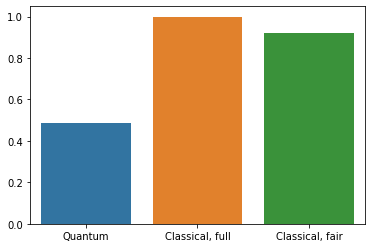

In [34]:
qnn_accuracy = qnn_results[1]
cnn_accuracy = cnn_results[1]
fair_nn_accuracy = fair_nn_results[1]

sns.barplot(["Quantum", "Classical, full", "Classical, fair"],
            [qnn_accuracy, cnn_accuracy, fair_nn_accuracy])